# hetan: ridge regression on macro variables and a basket of related stocks is what i’d suggest

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas_datareader as pdr
import quantstats as qs
import pytz

import datetime as dt

from sklearn import linear_model

In [2]:
snp_data = pd.read_csv('../Data/Structured_Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()

In [4]:
pd.__version__

'1.4.3'

# Try Hetan's suggestion - rough generalization of pairs trading on multiple assets

In [3]:
# tickerName: string, a single ticker
# period can be '_mo', '_
def downloadClosingPrices(tickerName, period='6mo'):
    return yf.Ticker(tickerName).history(period=period)[['Close']]

# closingPrices: a Pandas Dataframe of closing prices
# returns a list of returns
def getReturns(closingPrices):
    return closingPrices.pct_change(1).dropna() #closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))

# tickerNames: a list of strings of ticker names
# returns a dictionary of ticker names to lists of their daily returns
def makeDailyReturnsDf(tickerNames, period='6mo'):
    ticker_data = {}
  
    longestIndex = pd.Series(dtype='float64')
    # retrieve data
    for t in tickerNames:
        # take over the past 6 months
        c = downloadClosingPrices(t, period)
        # store longest index
        if len(c.index) >= len(longestIndex):
            longestIndex = c.index[1:]
        # No data found, symbol may be delisted
        if len(c) == 0:
            continue
        else:
            ticker_data[t] = getReturns(c).rename(columns={"Close":t}).squeeze().tolist()
    # remove stocks which are not of the same length
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    # ticker_data
    return pd.DataFrame(ticker_data, index = longestIndex)

# tickersToPredict DOESN'T have to be a subset of tickers
# returns a dictionary with the name of the stock as keys and the LM predicting that stock as values
# trains pair-wise LMs using same-day returns of related stocks as predictors
def trainLM(tickers, tickerToPredict):

    X = makeDailyReturnsDf(tickers)
    y = makeDailyReturnsDf([tickerToPredict])

    lm = Ridge()
    if tickerToPredict in X.columns:
        X.drop(columns=tickerToPredict, inplace=True)
    lm.fit(X, y)
    print(tickerToPredict, lm.score(X, y))
    return lm

In [4]:
# TODO: change to return series?
## zscore fn to generate buy/sell signals on a daily basis
# takes the zscore of a particular day's prediction over a window of past days
# lm: the linear model predicting stock returns based on related stocks
# X: a dataframe of predictors - returns of stocks related to the target
# y: a list of the target stock's returns
# days: number of days back to scale over
def zscore(lm, X, y, days=30):
    # lookback = min(len(X), len(y), days)
    lookback = days
    # print('lookback',lookback)
    steps = len(X)
    z_ts = []
    for s in range(steps,lookback,-1):
        X_window, y_window = X.iloc[s-lookback:s,], y.iloc[s-lookback:s]
        # predict for the last lookback no. of days
        y_hats = lm.predict(X_window)
        # get the residuals
        y_res = y_window - y_hats

        # get residual for today
        y_res_t = y_res.iloc[-1]
        y_res_ex_t = y_res.iloc[:-1]

        scaler = StandardScaler()
        # fit scale based on residuals up to yesterday
        scaler.fit(np.asarray(y_res_ex_t).reshape(-1,1))

        # transform today's residual
        z_t = scaler.transform(np.asarray(y_res_t).reshape(-1,1))
        z_ts.append(z_t[0][0])
    return z_ts

## Make Rolling Regression model (without sentiment)

In [7]:
spy = makeDailyReturnsDf(["SPY"], '4y')
spy

,SPY
Date,
2018-11-09 00:00:00-05:00,-0.009768
2018-11-12 00:00:00-05:00,-0.018685
2018-11-13 00:00:00-05:00,-0.001871
2018-11-14 00:00:00-05:00,-0.006837
2018-11-15 00:00:00-05:00,0.010436
...,...
2022-11-01 00:00:00-04:00,-0.004376
2022-11-02 00:00:00-04:00,-0.025096
2022-11-03 00:00:00-04:00,-0.010297


In [8]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def Model(tickers_to_predict, tickers_as_predictors, window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        Xhist = makeDailyReturnsDf([t for t in tickers_as_predictors if t != tick], '4y')
        yhist = makeDailyReturnsDf([tick],'4y')
        Xyhist = pd.concat([Xhist, yhist], axis=1)
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = retsSpreads['Date'].dt.tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

# Compile lists of relevant stocks

In [9]:
snp_data[:10]

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value,Action
0,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,396,557,976,700",0.60%,21.67,6.21,32.78,Analyze
1,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$1,700,887,137,266",1.08%,22.04,8.83,9.80,Analyze
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.82,4.04,2.00,Analyze
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.69,4.04,1.96,Analyze
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$987,418,107,695",0.00%,42.54,2.07,6.80,Analyze
5,TSLA,Tesla Inc,Common stocks,Large cap,Consumer Discretionary,"$713,867,145,652",0.00%,80.33,11.48,19.79,Analyze
6,BRK.B,Berkshire Hathaway Inc. Class B,Common stocks,Large cap,Financials,"$648,469,030,904",0.00%,4.42,1.83,0.71,Analyze
7,UNH,Unitedhealth Group Inc,Common stocks,Large cap,Health Care,"$511,944,311,010",1.13%,29.14,1.73,6.99,Analyze
8,XOM,Exxon Mobil Corp,Common stocks,Large cap,Energy,"$466,400,177,773",3.10%,17.95,1.52,2.74,Analyze
9,JNJ,Johnson & Johnson,Common stocks,Large cap,Health Care,"$452,540,967,536",2.51%,22.51,4.77,5.97,Analyze


Some of the top tech stocks like Google are classified as "Communication Services", so we include those

In [10]:
top20_it_stocks = snp_data[snp_data['GICS Sector'] == 'Information Technology']['Symbol'].to_list()[:20]
top20_stocks = snp_data['Symbol'].to_list()[:20]
top20_comm_stocks = snp_data[snp_data['GICS Sector']=='Communication Services']['Symbol'].to_list()[:20]
top20_it_comm_stocks = snp_data[snp_data['GICS Sector'].isin(['Information Technology', 'Communication Services'])]['Symbol'].to_list()[:20]

In [11]:
top20_it_comm_stocks

['AAPL',
 'MSFT',
 'GOOG',
 'GOOGL',
 'V',
 'NVDA',
 'MA',
 'META',
 'ORCL',
 'DIS',
 'AVGO',
 'TMUS',
 'ACN',
 'CSCO',
 'CRM',
 'VZ',
 'TXN',
 'ADBE',
 'CMCSA',
 'QCOM']

100%|██████████| 1/1 [00:10<00:00, 10.67s/it]

ols.rsquared Date
2018-11-09 00:00:00-05:00    NaN
2018-11-12 00:00:00-05:00    NaN
2018-11-13 00:00:00-05:00    NaN
2018-11-14 00:00:00-05:00    NaN
2018-11-15 00:00:00-05:00    NaN
                            ... 
2022-11-01 00:00:00-04:00    1.0
2022-11-02 00:00:00-04:00    1.0
2022-11-03 00:00:00-04:00    1.0
2022-11-04 00:00:00-04:00    1.0
2022-11-07 00:00:00-05:00    1.0
Length: 1005, dtype: float64


                           Strategy
-------------------------  ----------
Start Period               2019-05-06
End Period                 2022-11-07
Risk-Free Rate             2.0%
Time in Market             100.0%

Cumulative Return          164.2%
CAGR﹪                     31.89%

Sharpe                     0.91
Prob. Sharpe Ratio         88.83%
Smart Sharpe               0.78
Sortino                    1.33
Smart Sortino              1.14
Sortino/√2                 0.94
Smart Sortino/√2           0.8
Omega                      1.18

Max Drawdown               -31.43%
Longest DD Days            307
Volatility (ann.)          34.78%
Calmar                     1.01
Skew                       -0.03
Kurtosis                   4.45

Expected Daily %           0.11%
Expected Monthly %         2.29%
Expected Yearly %          27.49%
Kelly Criterion            8.29%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.47%
Expected Shortfall (cVaR)  -3.47%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-13,2020-03-23,2020-06-05,113,-31.426154,-29.937769
2,2022-01-04,2022-06-16,2022-11-07,307,-27.210086,-26.370598
3,2020-09-02,2020-09-18,2020-12-28,117,-20.375479,-20.166803
4,2021-01-27,2021-03-08,2021-07-07,161,-18.598451,-16.066058
5,2019-05-07,2019-06-03,2019-07-23,77,-16.554035,-15.701797


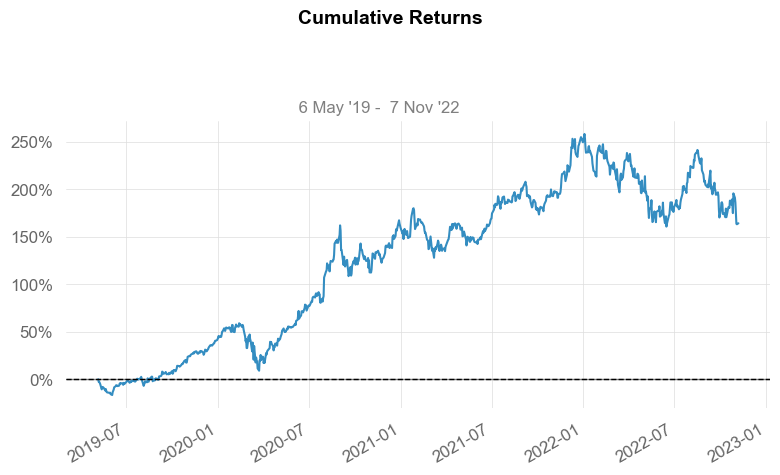

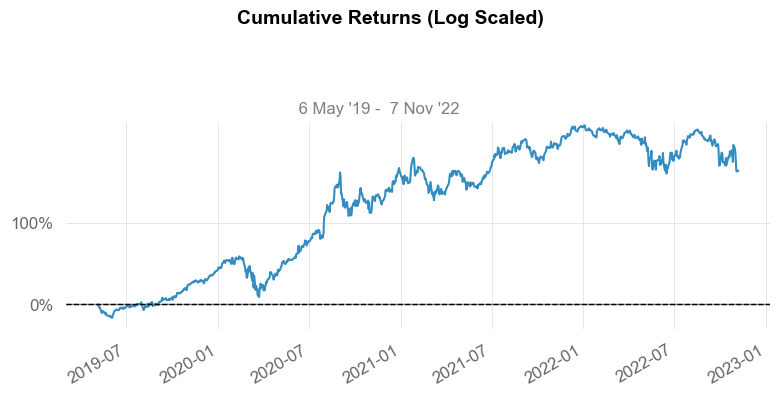

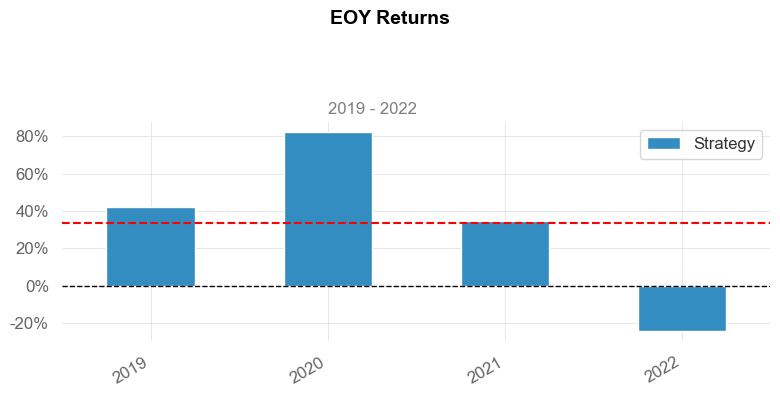

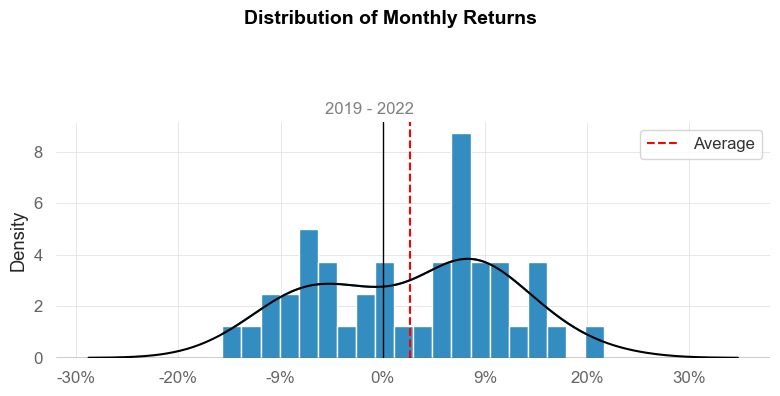

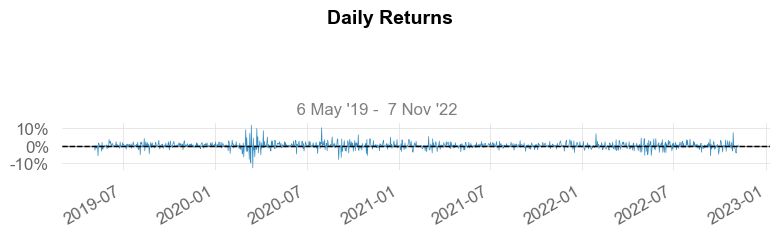

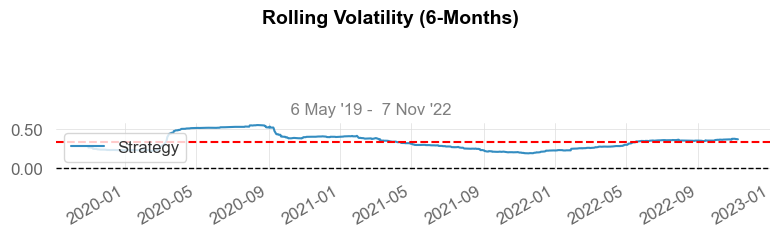

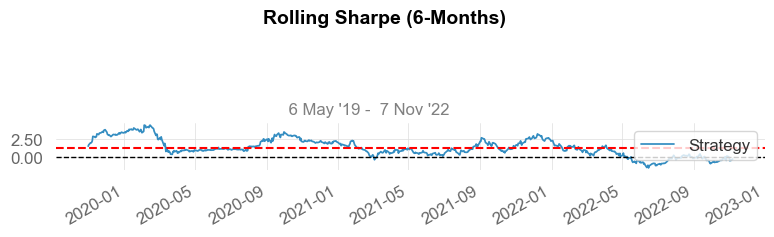

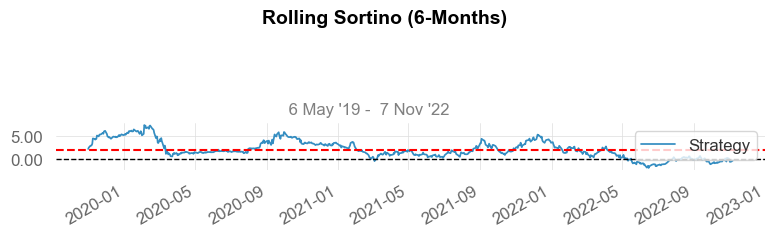

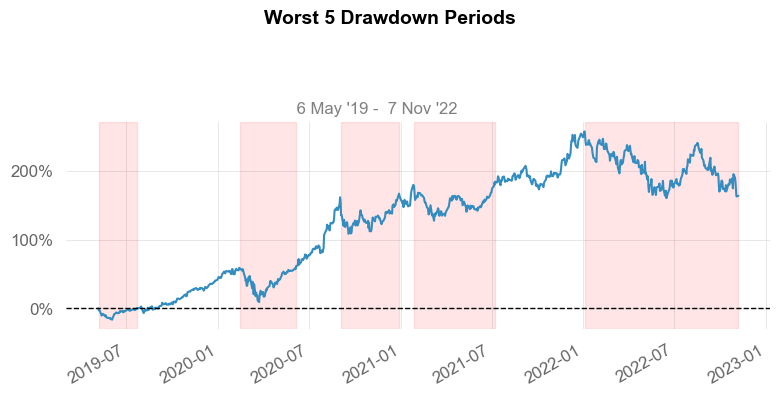

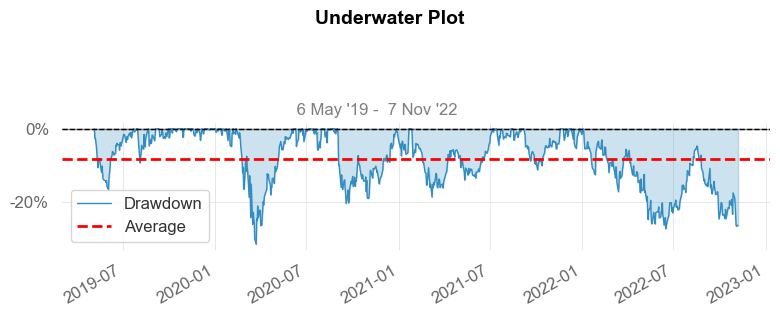

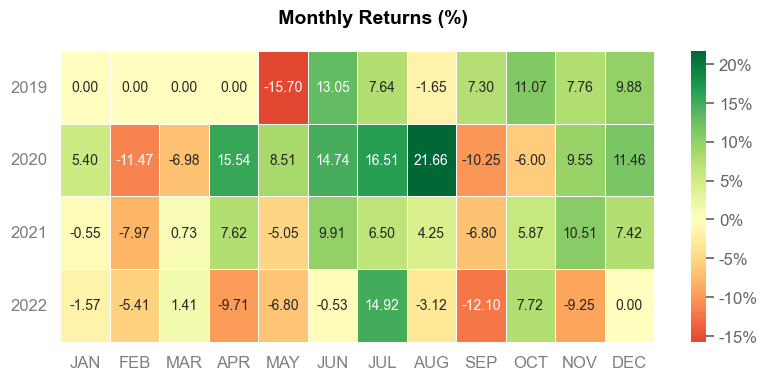

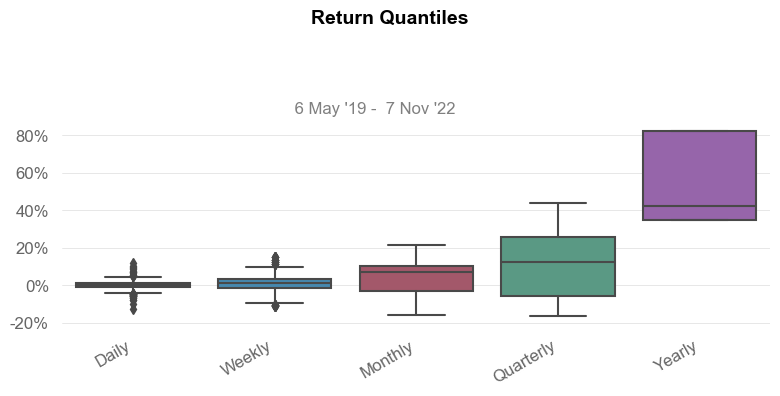

In [12]:
Model(['AAPl'], top20_it_comm_stocks)

# Try Model with incorporation of sentiment

cache returns data into csvs so that we don't get the newest data from dynamic calls to yahoo finance. This allows us to match the dates with those from the predictions from the sentiment analyses techniques which are also not dynamic and stored in csvs.

In [13]:
# top20_it_stocks_df = makeDailyReturnsDf(top20_it_stocks, '1y')
# top20_it_stocks_df.to_csv('../Data/Structured_Data/top20_it_stocks.csv')
# top20_it_comm_stocks_df = makeDailyReturnsDf(top20_it_comm_stocks, '1y')
# top20_it_comm_stocks_df.to_csv('../Data/Structured_Data/top20_it_comm_stocks.csv')

In [14]:
# AAPL = makeDailyReturnsDf(['AAPL'], '1y')
# AAPL.to_csv('../Data/Structured_Data/AAPL.csv')
# TSLA = makeDailyReturnsDf(['TSLA'], '1y')
# TSLA.to_csv('../Data/Structured_Data/TSLA.csv')
# META = makeDailyReturnsDf(['META'], '1y')
# META.to_csv('../Data/Structured_Data/META.csv')

In [5]:
def readDailyReturnsFromCsv(tickerNames, period='6mo', filepath='../Data/Structured_Data/'):
    ticker_data = {}
    longestIndex = pd.Series(dtype='float64')
    for t in tickerNames:
        df = pd.read_csv(filepath+t+'.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index, utc=True).date
        df.index.rename('Date', inplace=True)
        ticker_data[t] = df
        if df.shape[0] >= len(longestIndex):
            longestIndex = df.index[1:]
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    combined = pd.concat(list(ticker_data.values()))
    return combined
    

In [17]:
readDailyReturnsFromCsv(['TSLA',])

,TSLA
Date,
2021-11-09,-0.119903
2021-11-10,0.043429
2021-11-11,-0.004158
2021-11-12,-0.028293
2021-11-15,-0.019382
...,...
2022-11-01,0.001231
2022-11-02,-0.056360
2022-11-03,0.001535


# Sentiment Model (no grid search)

In [6]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def ModelwSentiment(tickers_to_predict=['AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        #TODO: read from csv file instead of pulling live data to match the sentiment predictions by Elton
        yhist = readDailyReturnsFromCsv([tick])
        yhist.index = pd.to_datetime(yhist.index, utc=True).date
        yhist.index.rename('Date', inplace=True)


        # returns data
        Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
        if tick in Xhist_rets.columns:
            Xhist_rets.drop(columns=tick, inplace=True)
        Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
        Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        # get betas
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                #TODO: add sentiment here
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        # get weights
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                #TODO: add sentiment here
                # spread is the residuals
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        # drop predicted sentiment data as tradeable stock
        if tick in betas.columns:
            betas.drop(columns=tick, inplace=True)
        if tick in weights.columns:
            weights.drop(columns=tick, inplace=True)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()
    print(retsSpreads)

    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    print(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02))
    # qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

In [24]:
ModelwSentiment(tickers_to_predict=['META'], sentiment_file='/stacked_pred_returns_rfr_test.csv')

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/705588631.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.730800
2022-08-26    0.723504
2022-08-29    0.724522
2022-08-30    0.722624
2022-08-31    0.711852
Length: 172, dtype: float64
          Date         0
0   2022-06-16  0.000000
1   2022-06-17 -0.001681
2   2022-06-21  0.003307
3   2022-06-22 -0.000593
4   2022-06-23 -0.001276
5   2022-06-24  0.011456
6   2022-06-27 -0.002490
7   2022-06-28 -0.001331
8   2022-06-29 -0.002060
9   2022-06-30 -0.003793
10  2022-07-01 -0.001829
11  2022-07-05  0.002901
12  2022-07-06  0.001278
13  2022-07-07  0.005628
14  2022-07-08 -0.000121
15  2022-07-11 -0.002500
16  2022-07-12 -0.003615
17  2022-07-13 -0.002542
18  2022-07-14  0.000167
19  2022-07-15  0.004135
20  2022-07-18  0.000615
21  2022-07-19  0.006639
22  2022-07-20  0.004878
23  2022-07-21  0.005470
24  2022-07-22 -0.007652
25  2022-07-25 -0.002558
26  2022-07-26 -0.005478
2

1.3452998398033476


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.722723
2022-08-26    0.710241
2022-08-29    0.708974
2022-08-30    0.708207
2022-08-31    0.708241
Length: 172, dtype: float64


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


          Date         0
0   2022-06-16  0.000000
1   2022-06-17  0.001377
2   2022-06-21  0.000475
3   2022-06-22  0.000736
4   2022-06-23  0.002423
5   2022-06-24  0.002769
6   2022-06-27  0.000333
7   2022-06-28 -0.004850
8   2022-06-29 -0.001551
9   2022-06-30 -0.003386
10  2022-07-01  0.000271
11  2022-07-05  0.004068
12  2022-07-06  0.001502
13  2022-07-07  0.005962
14  2022-07-08  0.000824
15  2022-07-11 -0.006022
16  2022-07-12  0.000980
17  2022-07-13 -0.000162
18  2022-07-14  0.002540
19  2022-07-15  0.001764
20  2022-07-18 -0.001322
21  2022-07-19  0.004803
22  2022-07-20  0.005264
23  2022-07-21  0.003182
24  2022-07-22 -0.002162
25  2022-07-25 -0.001329
26  2022-07-26 -0.001145
27  2022-07-27  0.005081
28  2022-07-28 -0.003421
29  2022-07-29  0.003850
30  2022-08-01 -0.001181
31  2022-08-02 -0.000194
32  2022-08-03  0.006307
33  2022-08-04  0.002103
34  2022-08-05 -0.000572
35  2022-08-08 -0.002190
36  2022-08-09 -0.001058
37  2022-08-10  0.006009
38  2022-08-11 -0.000008


                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.41%
CAGR﹪                     12.13%

Sharpe                     1.83
Prob. Sharpe Ratio         80.06%
Smart Sharpe               1.71
Sortino                    2.78
Smart Sortino              2.59
Sortino/√2                 1.97
Smart Sortino/√2           1.83
Omega                      1.35

Max Drawdown               -1.45%
Longest DD Days            15
Volatility (ann.)          5.18%
Calmar                     8.39
Skew                       -0.32
Kurtosis                   0.28

Expected Daily %           0.04%
Expected Monthly %         0.8%
Expected Yearly %          2.41%
Kelly Criterion            16.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.49%
Expected Shortfall (cVaR)  -0.49%

Max Consecutive Wins       6
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-26,2022-08-31,15,-1.446182,-1.441078
2,2022-06-28,2022-06-30,2022-07-07,9,-0.975846,-0.949040
3,2022-07-11,2022-07-11,2022-07-19,8,-0.602224,-0.520872
4,2022-07-22,2022-07-26,2022-07-27,5,-0.462902,-0.348794
5,2022-08-05,2022-08-09,2022-08-10,5,-0.381542,-0.276052


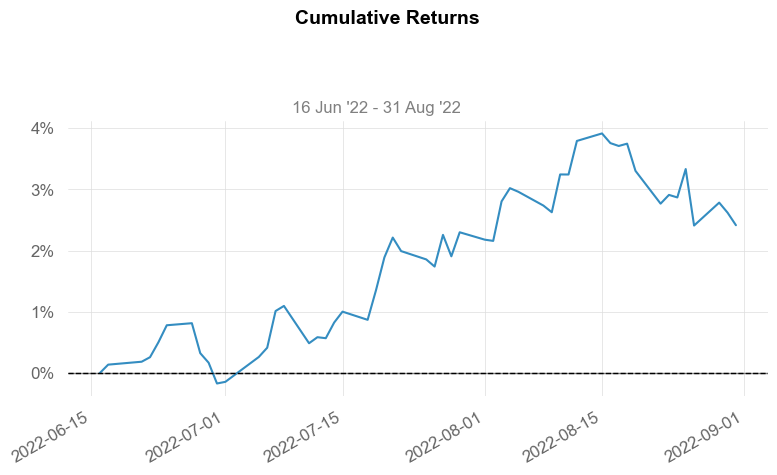

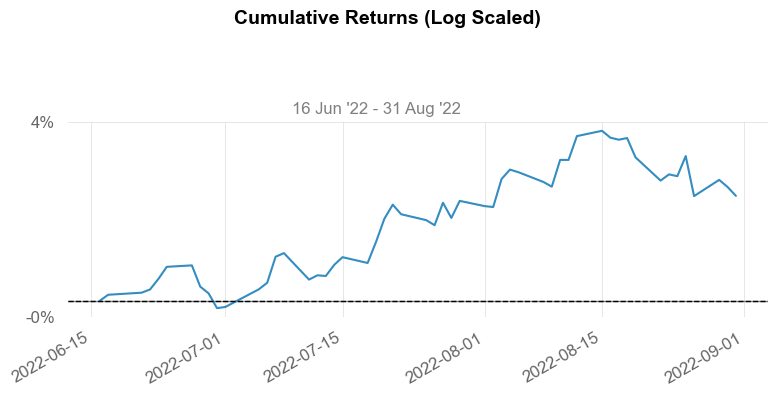

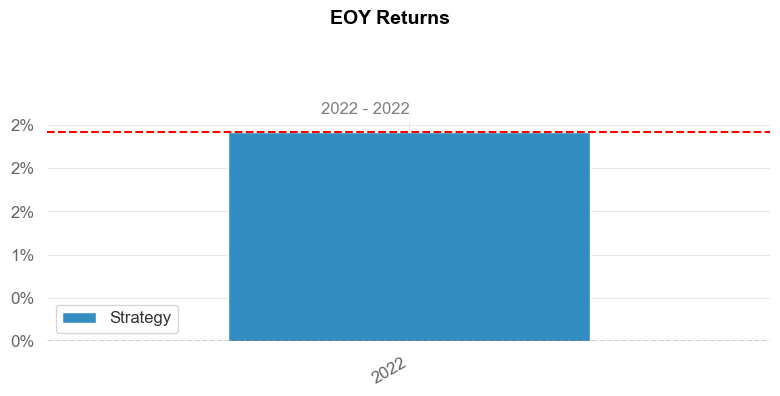

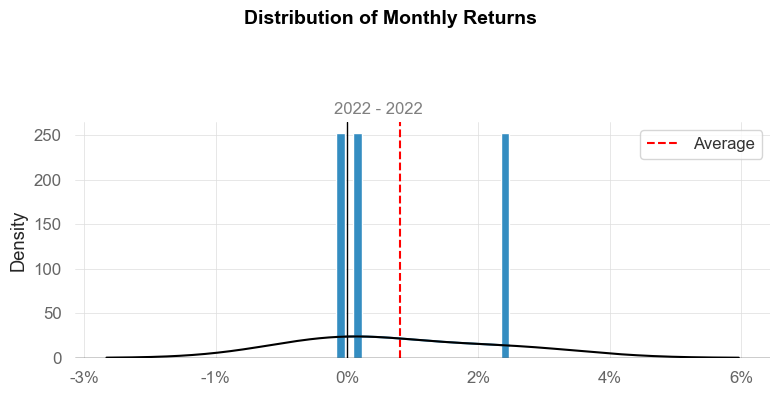

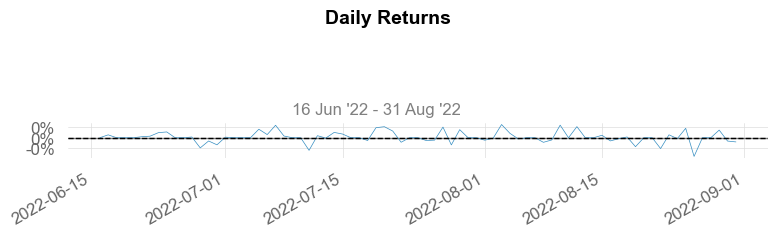

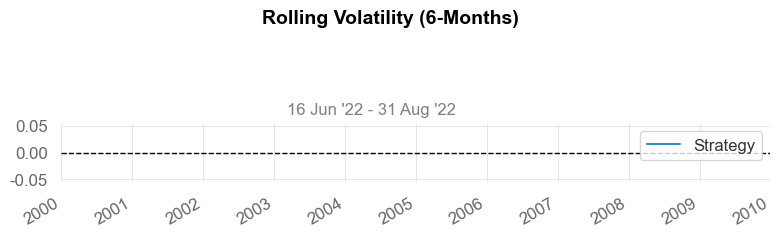

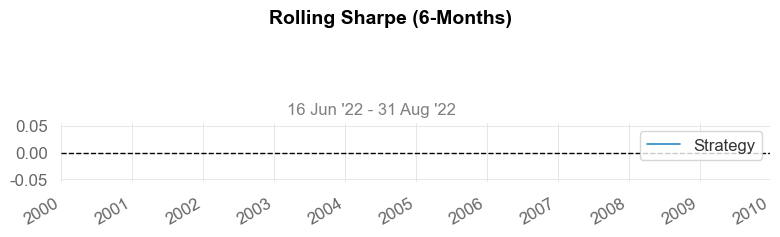

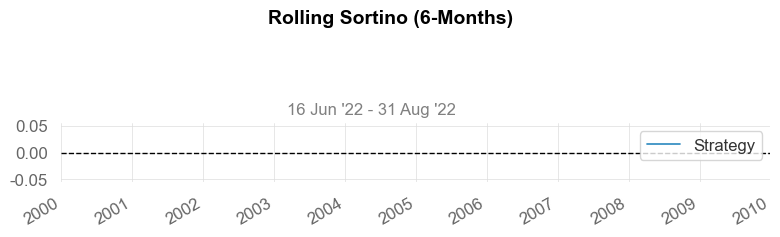

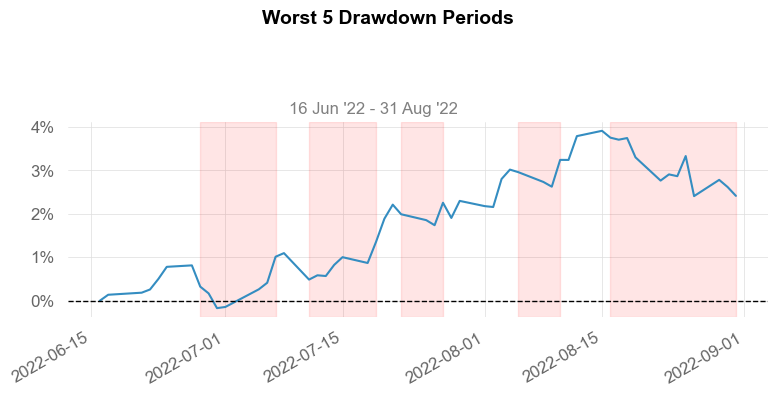

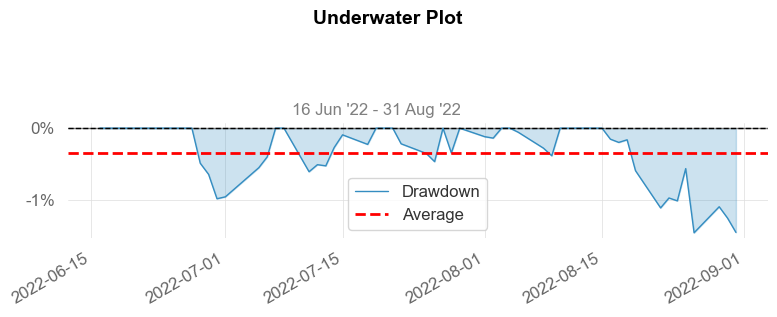

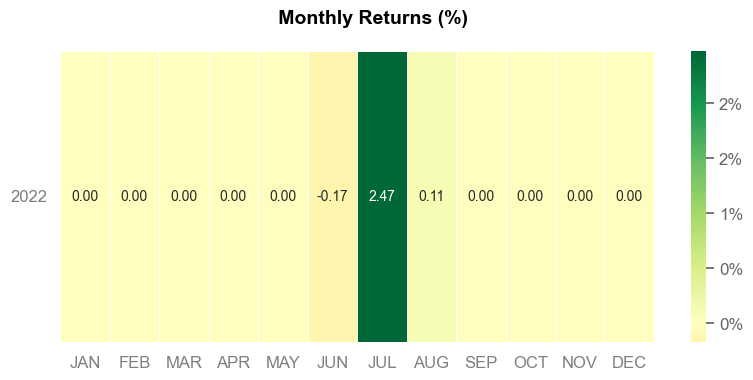

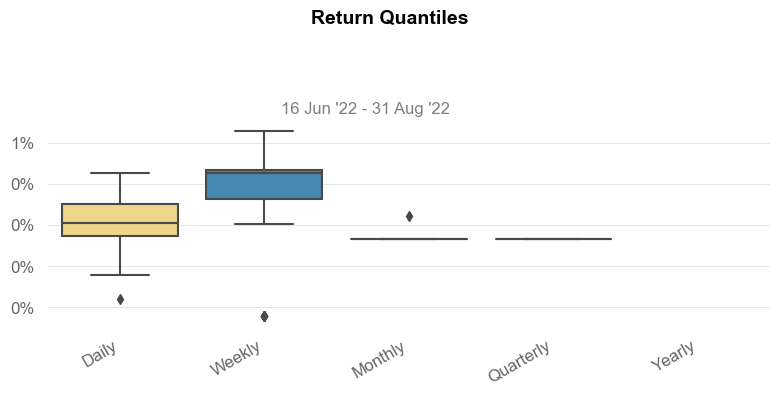

In [21]:
ModelwSentiment(tickers_to_predict=['TSLA'], sentiment_file='/stacked_pred_returns_rfr_test.csv')

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.834164
2022-08-26    0.843520
2022-08-29    0.843467
2022-08-30    0.840931
2022-08-31    0.844452
Length: 172, dtype: float64
          Date         0
0   2022-06-16  0.000000
1   2022-06-17  0.001710
2   2022-06-21  0.008556
3   2022-06-22 -0.001257
4   2022-06-23  0.002038
5   2022-06-24  0.009062
6   2022-06-27 -0.003118
7   2022-06-28 -0.005267
8   2022-06-29 -0.000276
9   2022-06-30 -0.004267
10  2022-07-01  0.001475
11  2022-07-05  0.002196
12  2022-07-06  0.001993
13  2022-07-07  0.004808
14  2022-07-08 -0.000865
15  2022-07-11 -0.003323
16  2022-07-12 -0.004163
17  2022-07-13  0.001388
18  2022-07-14 -0.000076
19  2022-07-15  0.005360
20  2022-07-18 -0.003637
21  2022-07-19  0.010543
22  2022-07-20  0.001603
23  2022-07-21  0.001162
24  2022-07-22 -0.010979
25  2022-07-25 -0.000587
26  2022-07-26 -0.005467
2

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          0.92%
CAGR﹪                     4.49%

Sharpe                     0.36
Prob. Sharpe Ratio         55.84%
Smart Sharpe               0.36
Sortino                    0.55
Smart Sortino              0.55
Sortino/√2                 0.39
Smart Sortino/√2           0.39
Omega                      1.06

Max Drawdown               -2.88%
Longest DD Days            22
Volatility (ann.)          7.19%
Calmar                     1.56
Skew                       0.23
Kurtosis                   0.49

Expected Daily %           0.02%
Expected Monthly %         0.31%
Expected Yearly %          0.92%
Kelly Criterion            4.92%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.73%
Expected Shortfall (cVaR)  -0.73%

Max Consecutive Wins       4
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-2.878560,-2.688659
2,2022-07-22,2022-07-26,2022-08-01,10,-1.696386,-1.156006
3,2022-06-27,2022-06-30,2022-07-19,22,-1.287241,-1.141676
4,2022-08-05,2022-08-09,2022-08-10,5,-0.423477,-0.268623
5,2022-08-02,2022-08-02,2022-08-03,1,-0.355574,0.000000


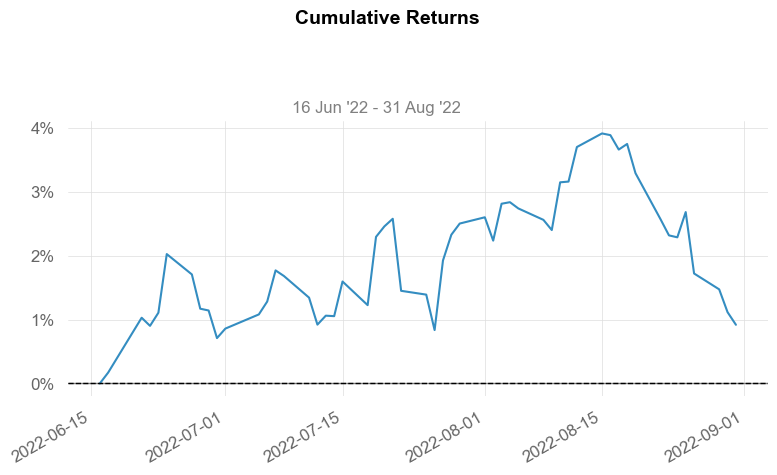

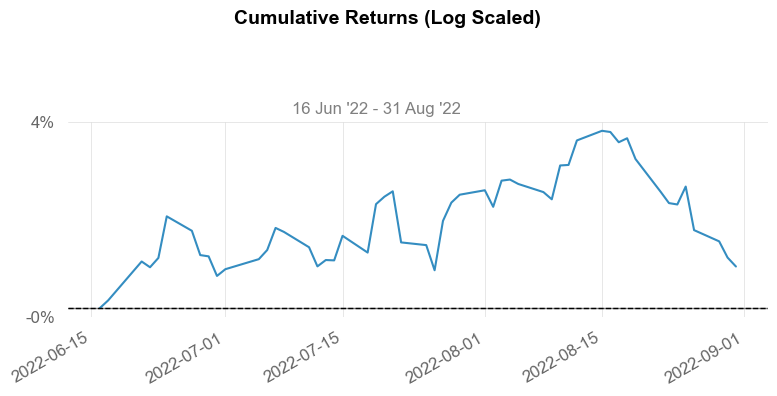

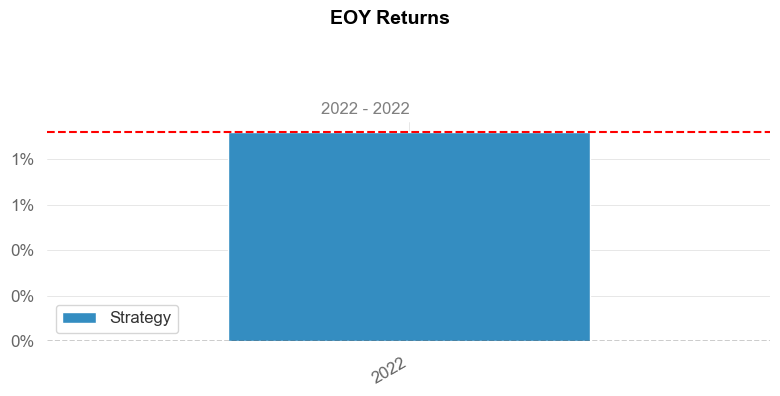

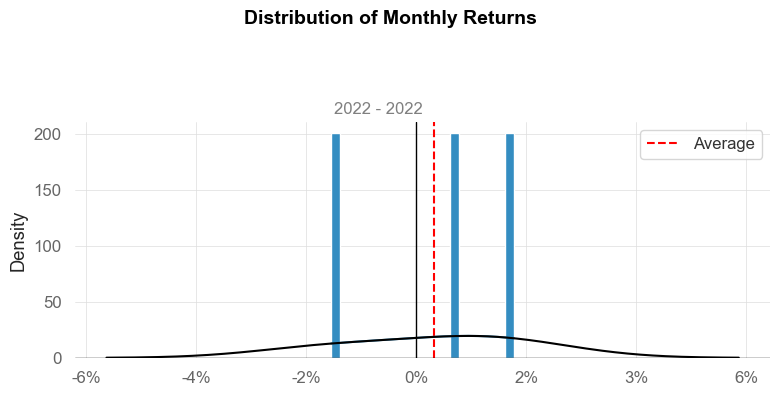

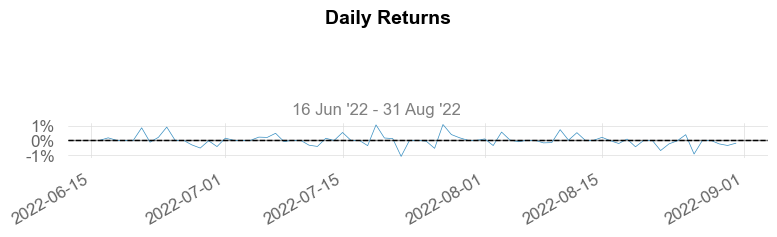

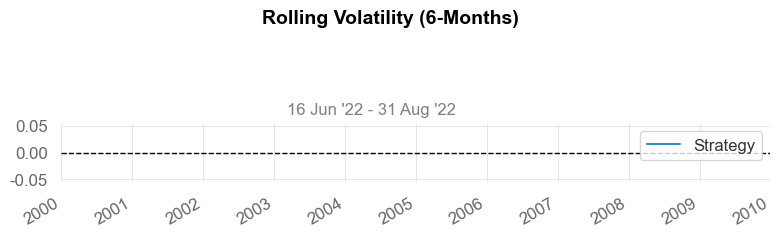

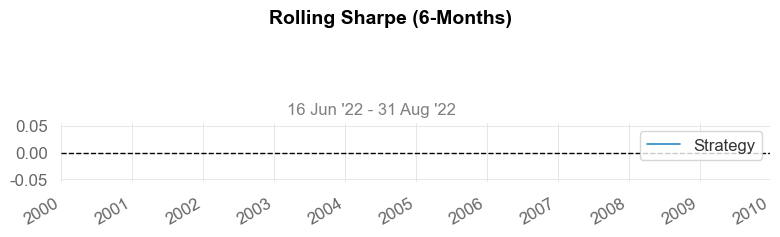

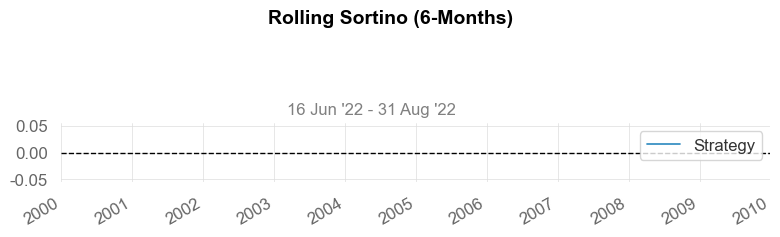

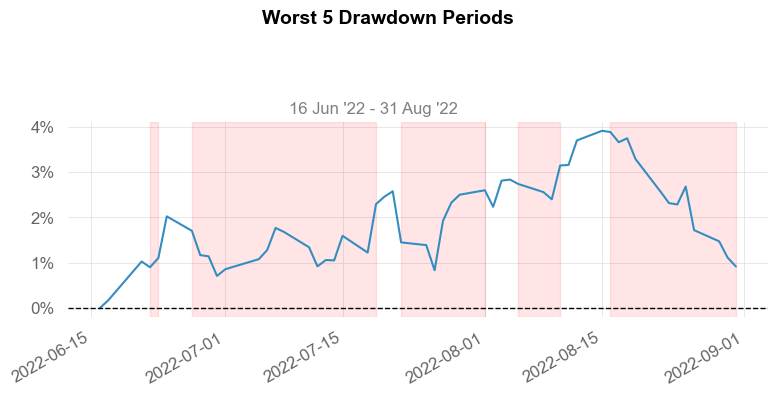

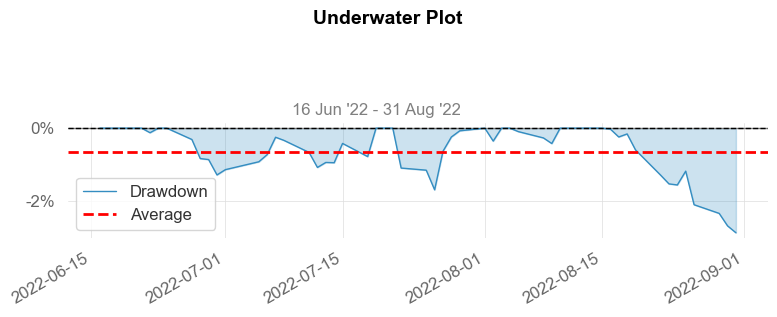

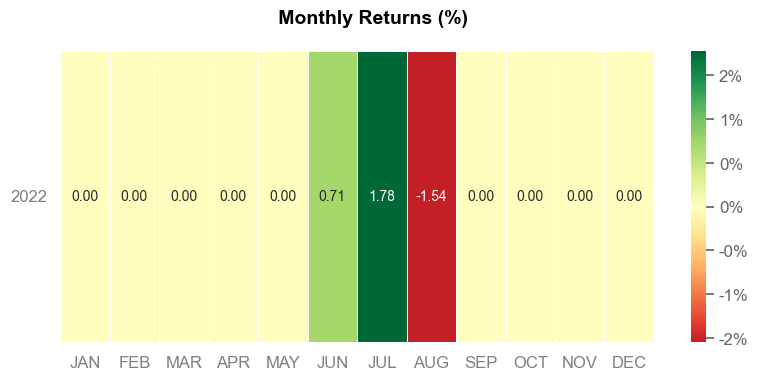

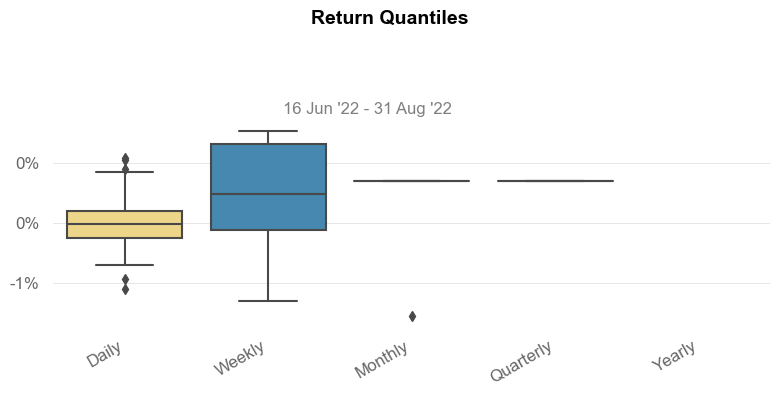

In [20]:
ModelwSentiment(tickers_to_predict=['AAPL'], sentiment_file='/stacked_pred_returns_rfr_test.csv')

predict the average of 3 stocks

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1295/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.73it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.731313
2022-08-26    0.719370
2022-08-29    0.717462
2022-08-30    0.716348
2022-08-31    0.716082
Length: 172, dtype: float64


/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1295/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.733564
2022-08-26    0.726322
2022-08-29    0.727322
2022-08-30    0.725264
2022-08-31    0.715572
Length: 172, dtype: float64
          Date         0         1
0   2022-06-16  0.000000  0.000000
1   2022-06-17  0.001585 -0.001504
2   2022-06-21  0.000570  0.003051
3   2022-06-22  0.000444 -0.000408
4   2022-06-23  0.002446 -0.000793
5   2022-06-24  0.003434  0.009674
6   2022-06-27  0.000291 -0.002102
7   2022-06-28 -0.004727 -0.001586
8   2022-06-29 -0.001528 -0.001478
9   2022-06-30 -0.003303 -0.003576
10  2022-07-01  0.000056 -0.001360
11  2022-07-05  0.004394  0.002871
12  2022-07-06  0.001312  0.000851
13  2022-07-07  0.007904  0.004542
14  2022-07-08  0.000300 -0.000256
15  2022-07-11 -0.006483 -0.001751
16  2022-07-12  0.001722 -0.002863
17  2022-07-13  0.000599 -0.002240
18  2022-07-14  0.002329  0.000561
1

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.3%
CAGR﹪                     11.53%

Sharpe                     1.77
Prob. Sharpe Ratio         79.87%
Smart Sharpe               1.69
Sortino                    2.83
Smart Sortino              2.71
Sortino/√2                 2.0
Smart Sortino/√2           1.91
Omega                      1.34

Max Drawdown               -1.53%
Longest DD Days            15
Volatility (ann.)          5.06%
Calmar                     7.54
Skew                       -0.01
Kurtosis                   -0.0

Expected Daily %           0.04%
Expected Monthly %         0.76%
Expected Yearly %          2.3%
Kelly Criterion            16.25%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.48%
Expected Shortfall (cVaR)  -0.48%

Max Consecutive Wins       5
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-26,2022-08-31,15,-1.528228,-1.497237
2,2022-06-27,2022-07-01,2022-07-07,10,-0.962186,-0.897616
3,2022-07-22,2022-07-26,2022-08-03,12,-0.946666,-0.643790
4,2022-07-11,2022-07-13,2022-07-19,8,-0.550157,-0.468489
5,2022-08-05,2022-08-09,2022-08-10,5,-0.429673,-0.206932


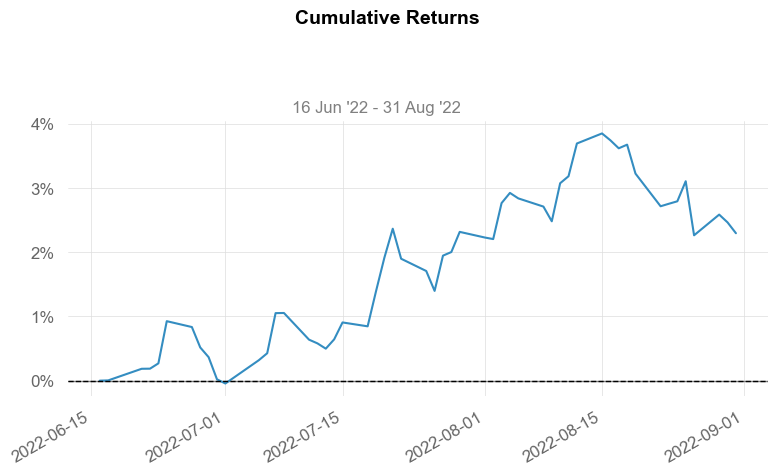

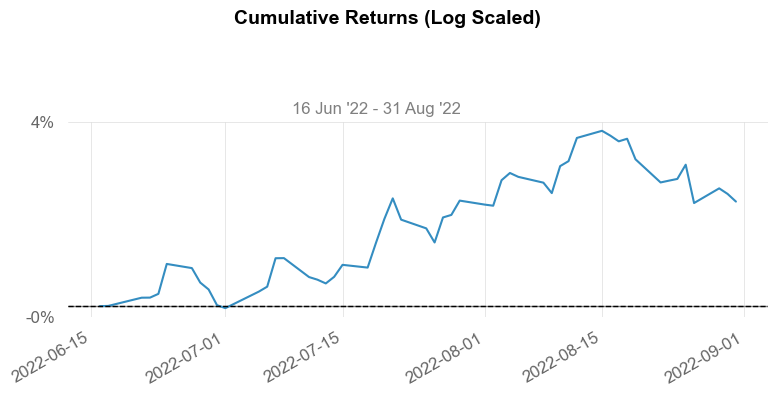

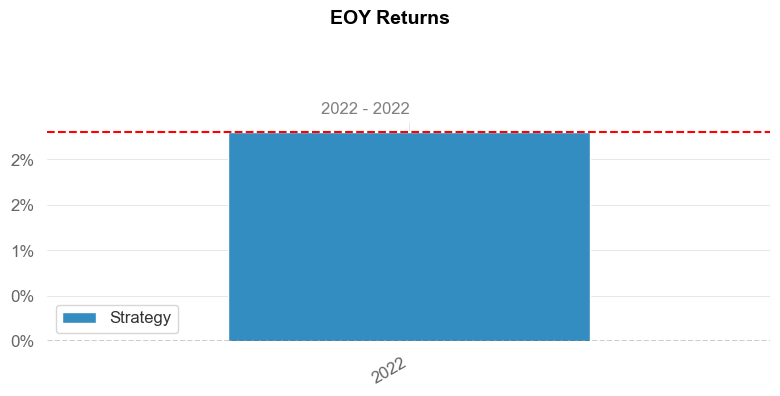

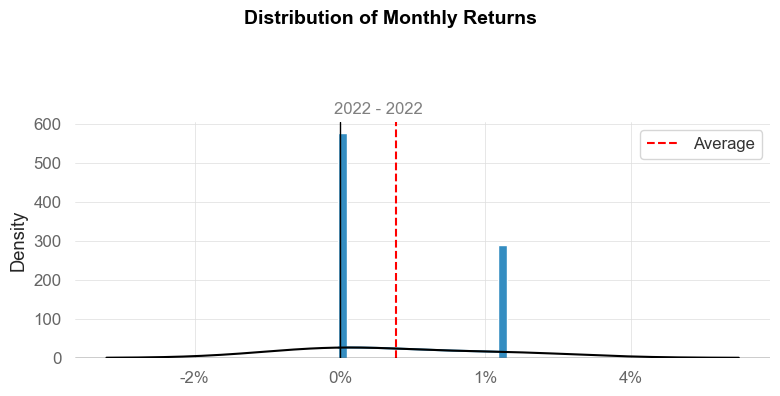

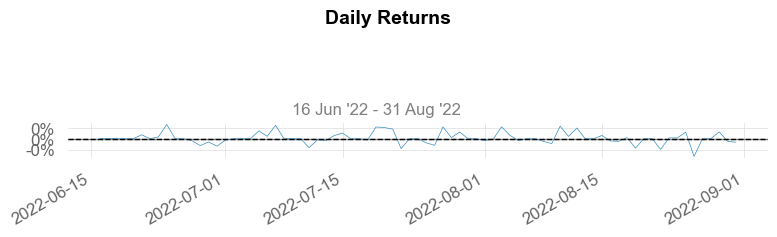

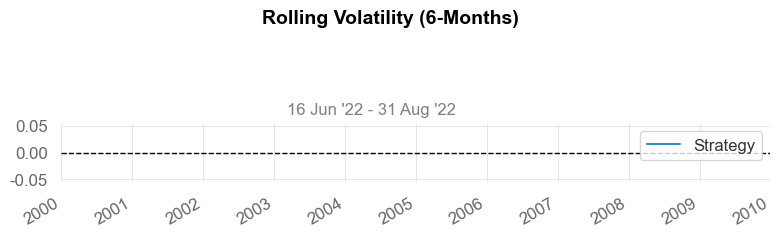

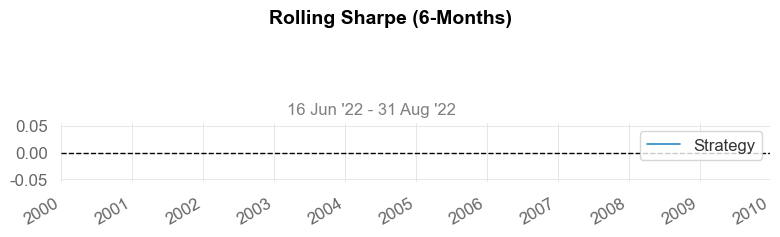

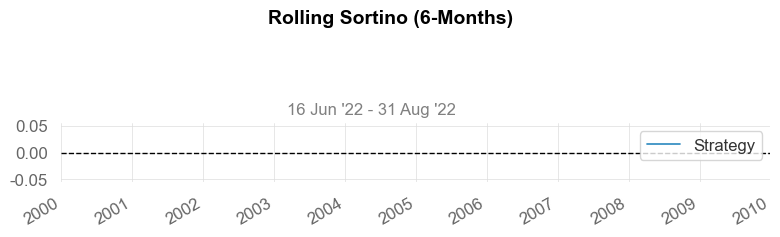

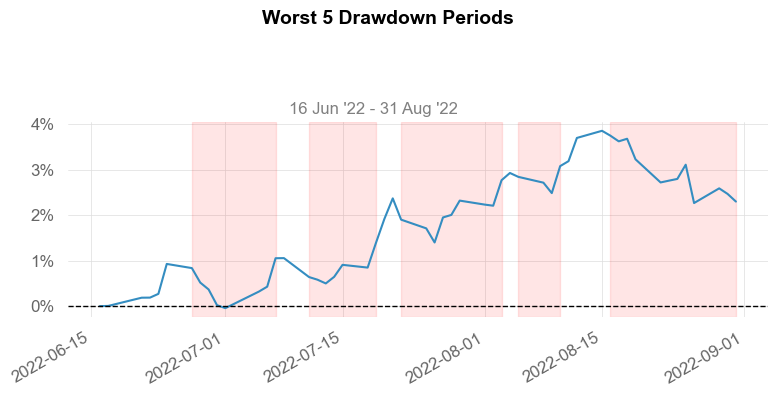

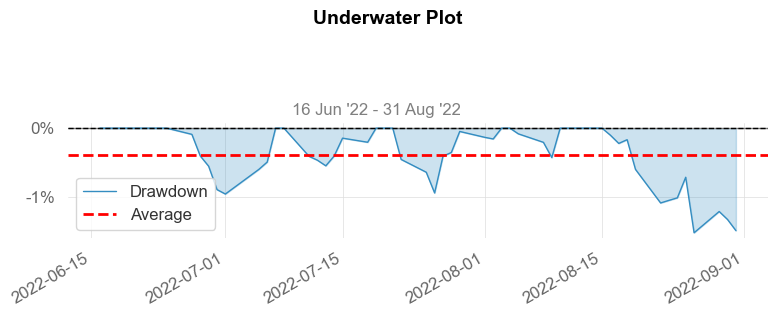

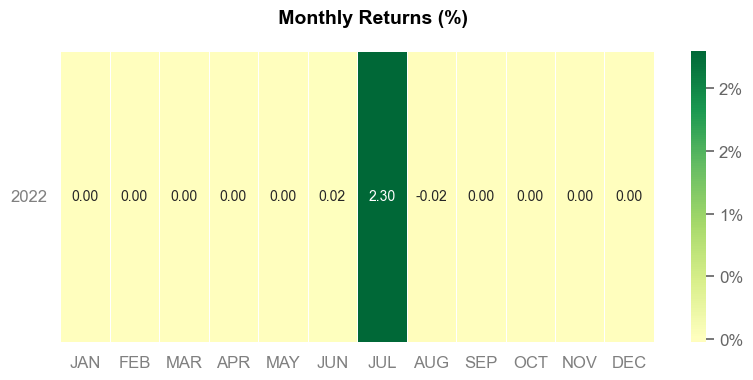

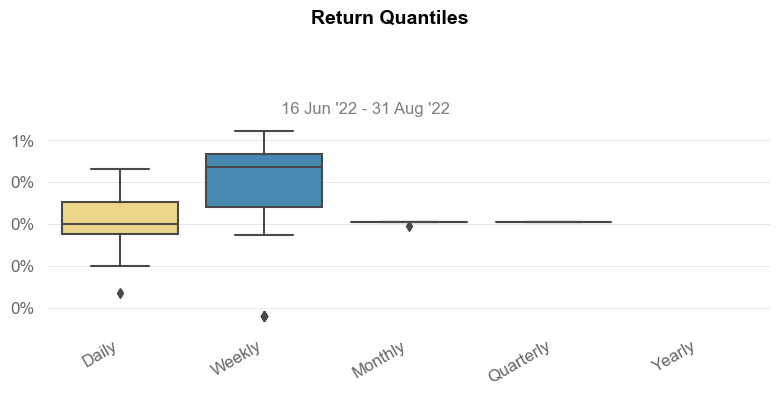

In [26]:
ModelwSentiment(tickers_to_predict=['AAPL', 'TSLA', 'META'])

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1295/3930470958.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.833660
2022-08-26    0.843686
2022-08-29    0.843779
2022-08-30    0.841206
2022-08-31    0.844212
Length: 172, dtype: float64
          Date         0
0   2022-06-16  0.000000
1   2022-06-17  0.001713
2   2022-06-21  0.008690
3   2022-06-22 -0.001298
4   2022-06-23  0.001920
5   2022-06-24  0.009065
6   2022-06-27 -0.003219
7   2022-06-28 -0.005395
8   2022-06-29 -0.000179
9   2022-06-30 -0.004247
10  2022-07-01  0.001498
11  2022-07-05  0.001940
12  2022-07-06  0.002058
13  2022-07-07  0.004882
14  2022-07-08 -0.000914
15  2022-07-11 -0.003280
16  2022-07-12 -0.004285
17  2022-07-13 -0.001555
18  2022-07-14 -0.000148
19  2022-07-15  0.005396
20  2022-07-18 -0.003835
21  2022-07-19  0.010655
22  2022-07-20  0.001535
23  2022-07-21  0.001163
24  2022-07-22 -0.010927
25  2022-07-25 -0.000594
26  2022-07-26 -0.005506
2

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          0.71%
CAGR﹪                     3.44%

Sharpe                     0.22
Prob. Sharpe Ratio         53.33%
Smart Sharpe               0.22
Sortino                    0.34
Smart Sortino              0.34
Sortino/√2                 0.24
Smart Sortino/√2           0.24
Omega                      1.04

Max Drawdown               -2.79%
Longest DD Days            23
Volatility (ann.)          7.19%
Calmar                     1.23
Skew                       0.31
Kurtosis                   0.54

Expected Daily %           0.01%
Expected Monthly %         0.23%
Expected Yearly %          0.71%
Kelly Criterion            3.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.73%
Expected Shortfall (cVaR)  -0.73%

Max Consecutive Wins       4
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-2.792545,-2.606079
2,2022-07-22,2022-07-26,2022-08-01,10,-1.695768,-1.151528
3,2022-06-27,2022-06-30,2022-07-20,23,-1.298351,-1.282189
4,2022-08-05,2022-08-09,2022-08-10,5,-0.410662,-0.260892
5,2022-08-02,2022-08-02,2022-08-03,1,-0.347287,0.000000


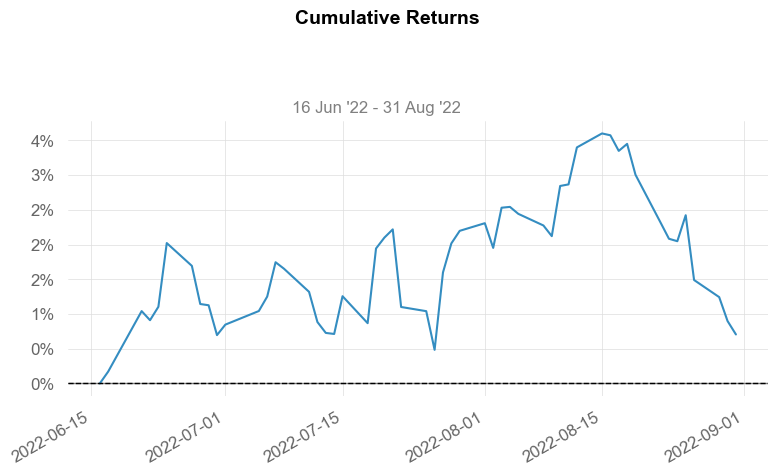

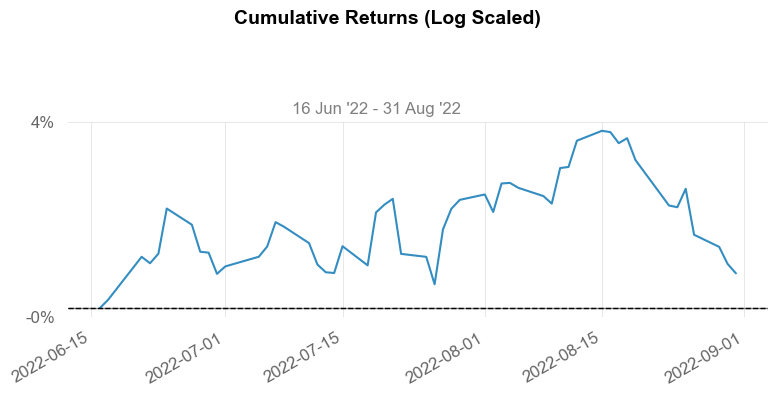

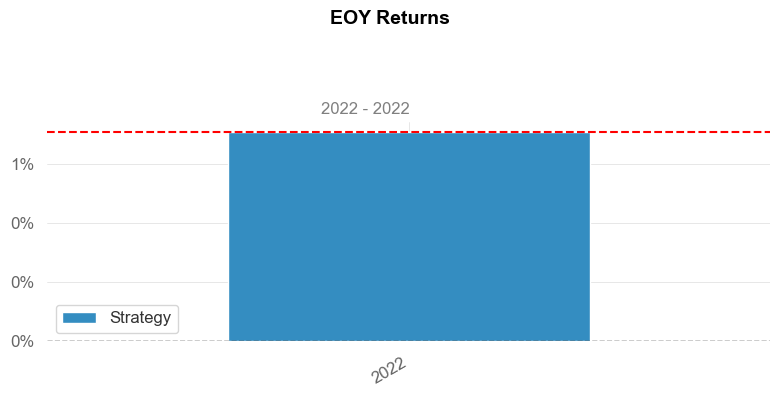

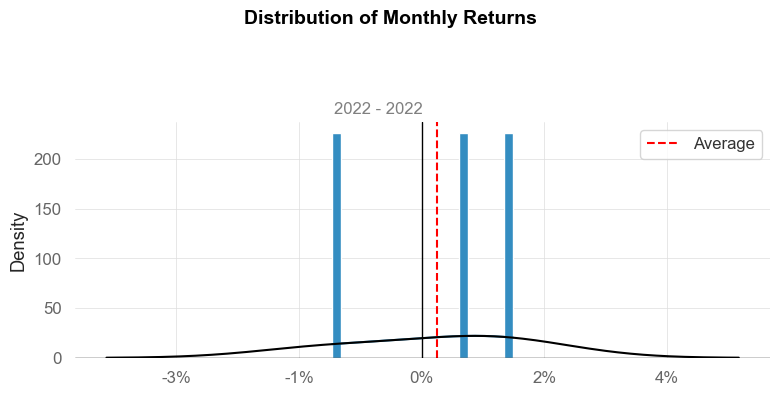

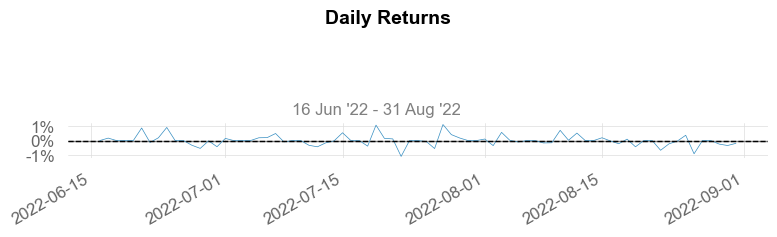

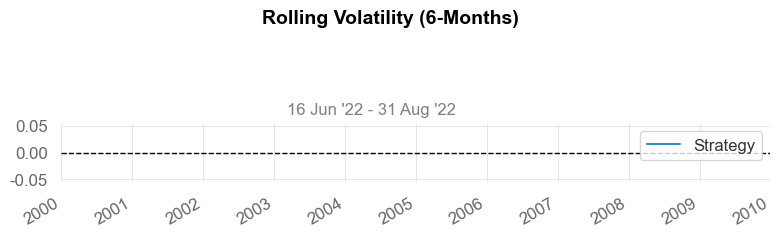

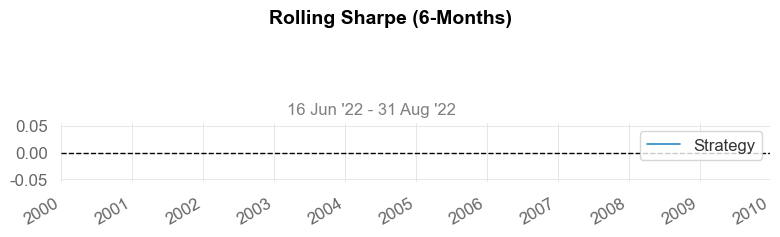

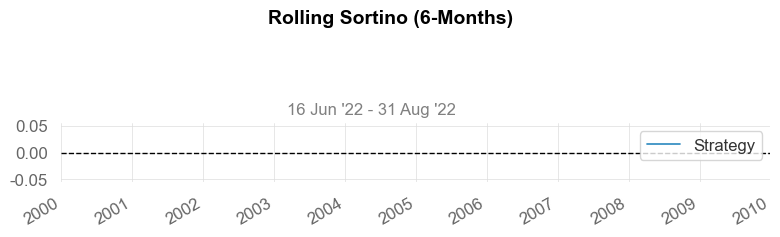

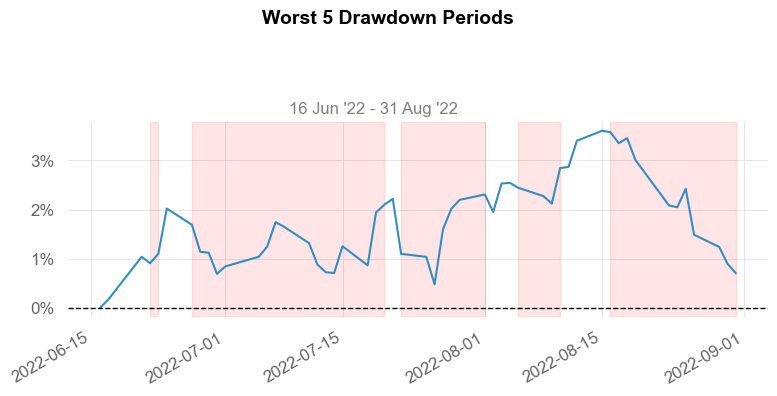

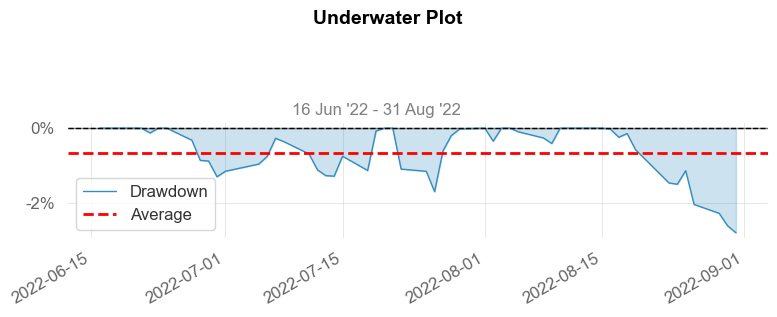

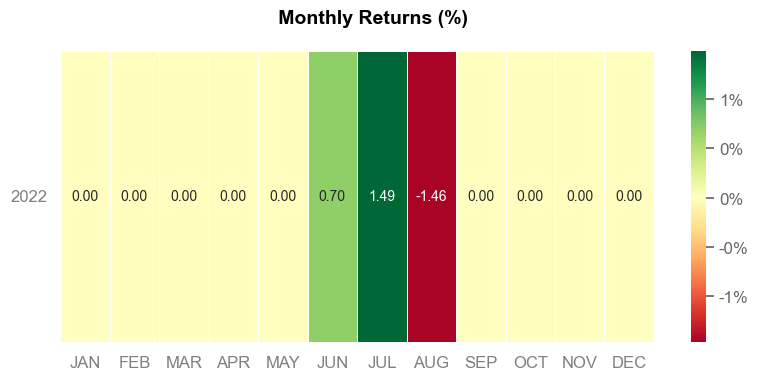

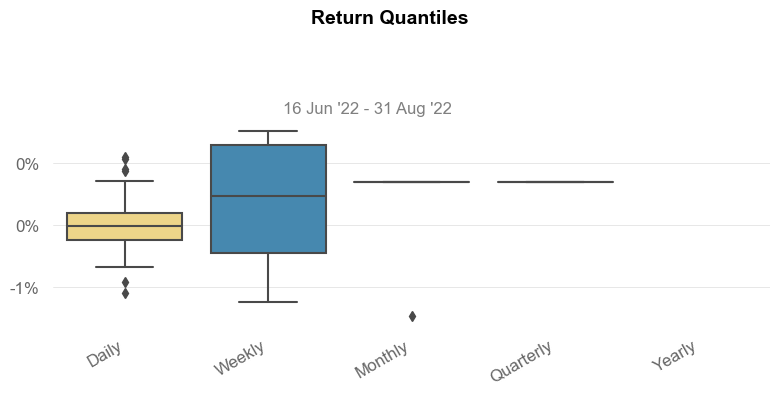

In [20]:
ModelwSentiment()

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1118/2588586244.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

Xhist_rets
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM'],
      dtype='object')
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM'],
      dtype='object')
initial weights
Index(['TSLA', 'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META',
       'ORCL', 'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN',
       'ADBE', 'CMCSA', 'QCOM', 'TSLA'],
      dtype='object')
betas.columns
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM', 'TSLA'],
      dtype='object')
betas.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM',

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.54%
CAGR﹪                     12.83%

Sharpe                     2.02
Prob. Sharpe Ratio         82.49%
Smart Sharpe               1.89
Sortino                    3.1
Smart Sortino              2.89
Sortino/√2                 2.19
Smart Sortino/√2           2.04
Omega                      1.39

Max Drawdown               -1.37%
Longest DD Days            15
Volatility (ann.)          4.99%
Calmar                     9.39
Skew                       -0.31
Kurtosis                   0.17

Expected Daily %           0.05%
Expected Monthly %         0.84%
Expected Yearly %          2.54%
Kelly Criterion            17.57%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.47%
Expected Shortfall (cVaR)  -0.47%

Max Consecutive Wins       6
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-1.365523,-1.357951
2,2022-06-28,2022-06-30,2022-07-07,9,-0.923811,-0.878987
3,2022-07-11,2022-07-11,2022-07-19,8,-0.572075,-0.488123
4,2022-07-22,2022-07-26,2022-07-27,5,-0.428110,-0.319433
5,2022-08-05,2022-08-09,2022-08-10,5,-0.372925,-0.266999


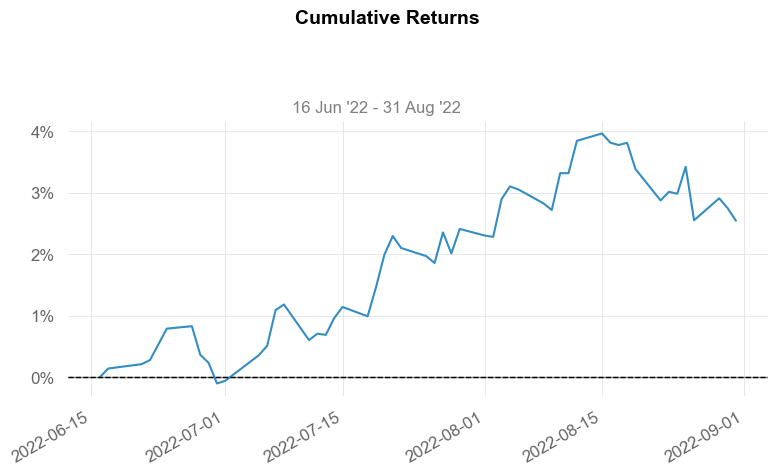

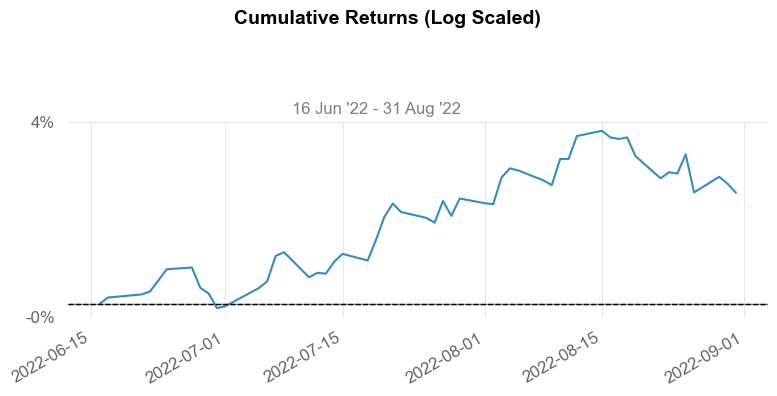

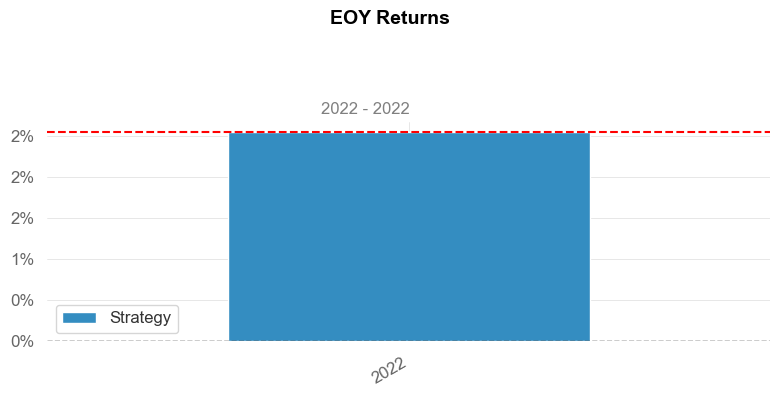

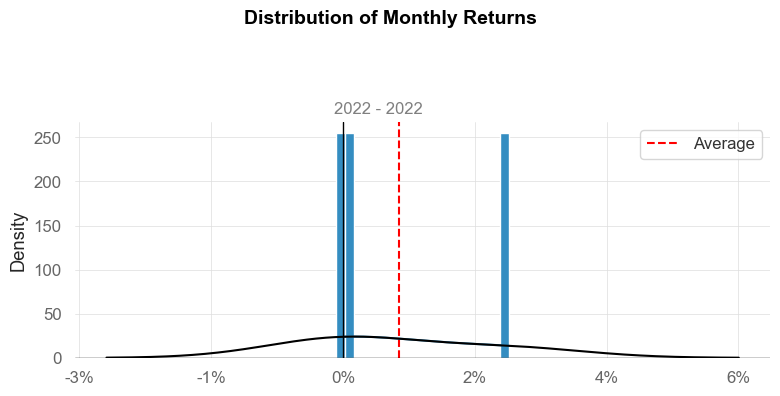

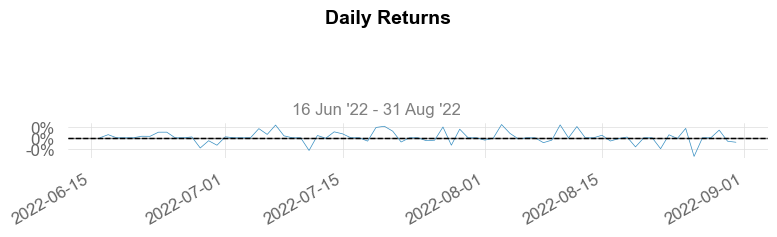

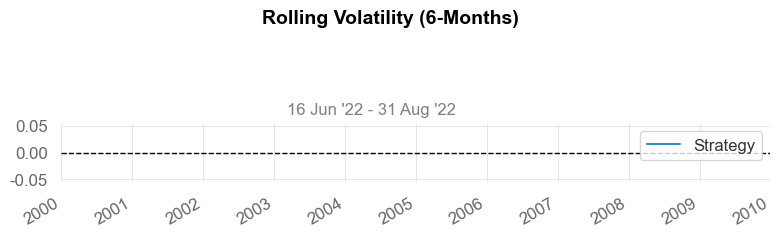

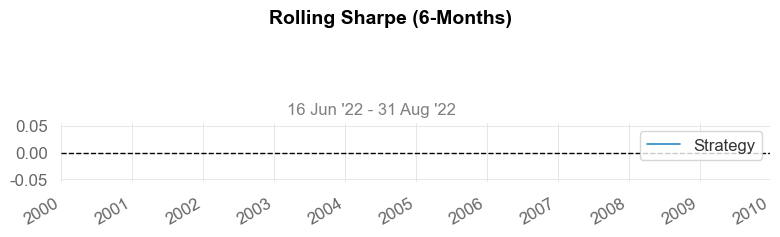

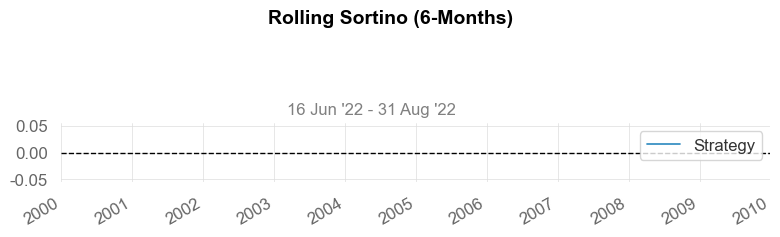

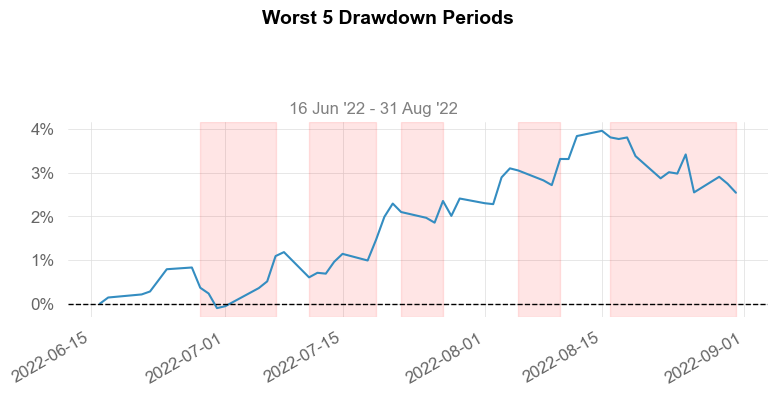

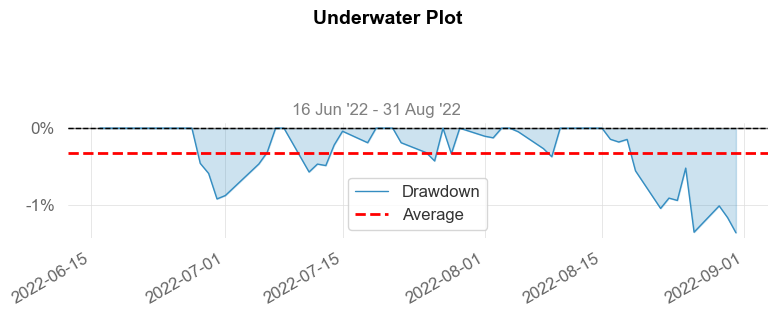

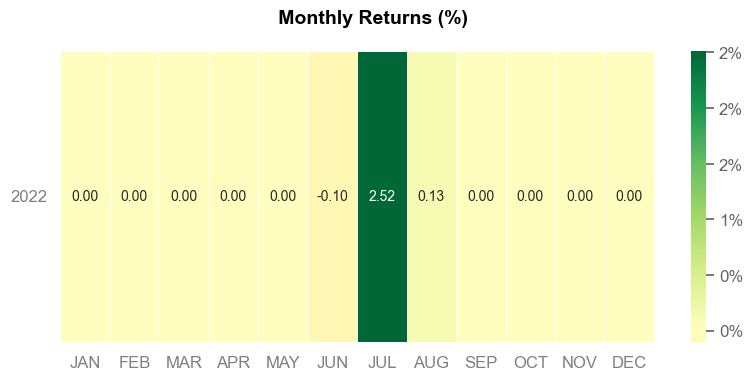

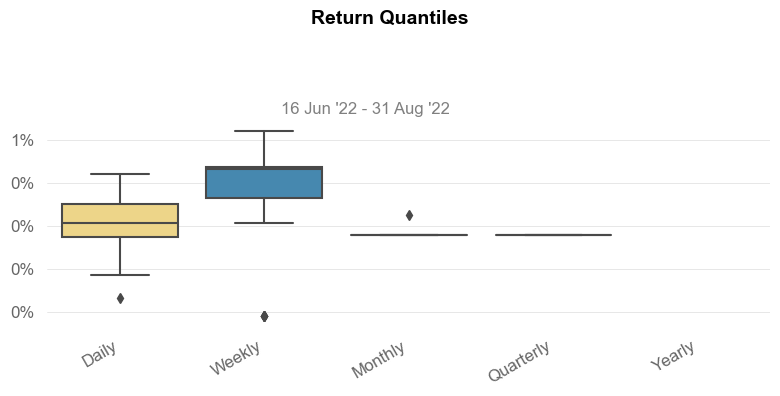

In [57]:
ModelwSentiment(tickers_to_predict=['TSLA'])

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1118/1552830259.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

initial weights
Index(['META', 'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM', 'META'],
      dtype='object')
betas.columns
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM', 'META'],
      dtype='object')
betas.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM'],
      dtype='object')
weights.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM'],
      dtype='object')
weights
                AAPL      MSFT      GOOG     GOOGL         V      NVDA  \
Date                                                    

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          1.99%
CAGR﹪                     9.9%

Sharpe                     1.35
Prob. Sharpe Ratio         73.79%
Smart Sharpe               1.25
Sortino                    2.13
Smart Sortino              1.98
Sortino/√2                 1.51
Smart Sortino/√2           1.4
Omega                      1.25

Max Drawdown               -1.58%
Longest DD Days            22
Volatility (ann.)          5.57%
Calmar                     6.28
Skew                       0.16
Kurtosis                   0.33

Expected Daily %           0.04%
Expected Monthly %         0.66%
Expected Yearly %          1.99%
Kelly Criterion            13.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.54%
Expected Shortfall (cVaR)  -0.54%

Max Consecutive Wins       7
Max 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-26,2022-08-31,15,-1.577517,-1.560159
2,2022-07-22,2022-07-26,2022-08-02,11,-1.449669,-0.934868
3,2022-06-27,2022-07-01,2022-07-19,22,-1.002022,-0.873615
4,2022-08-05,2022-08-09,2022-08-10,5,-0.450513,-0.089158
5,2022-06-17,2022-06-17,2022-06-21,4,-0.150508,0.000000


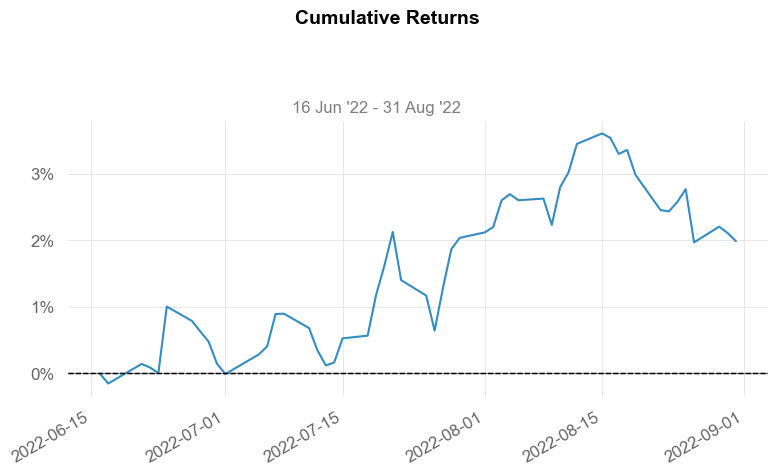

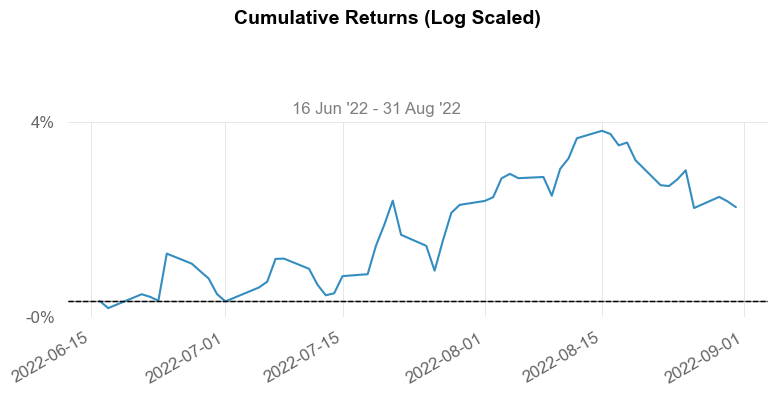

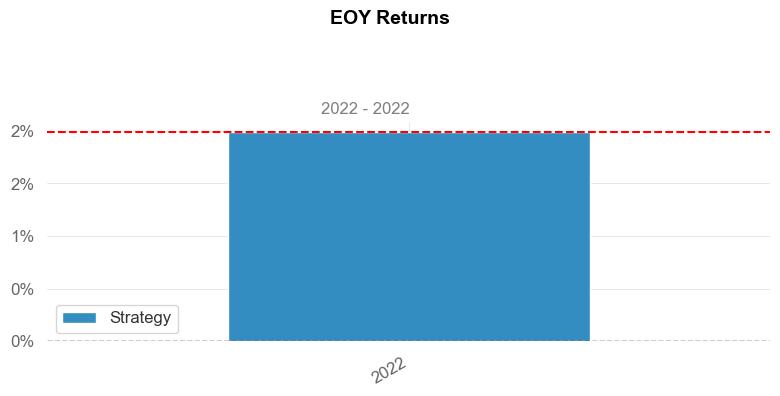

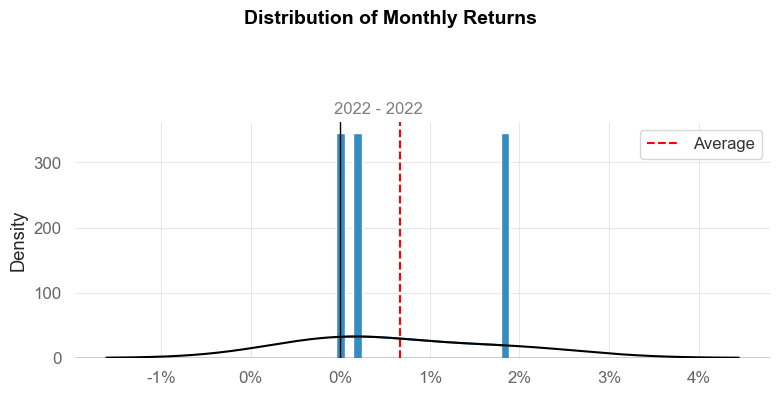

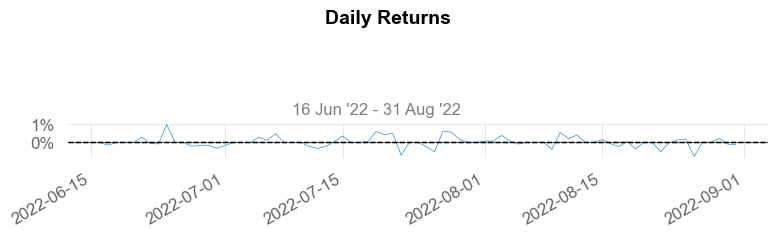

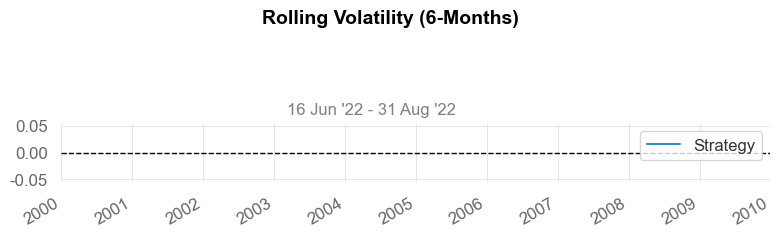

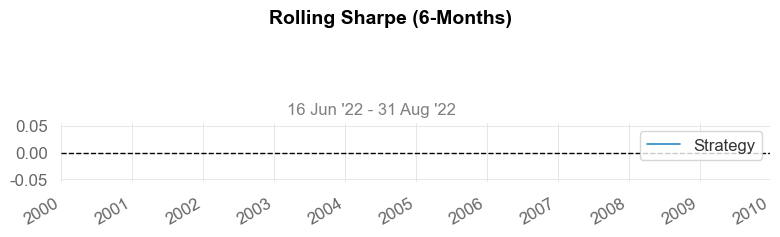

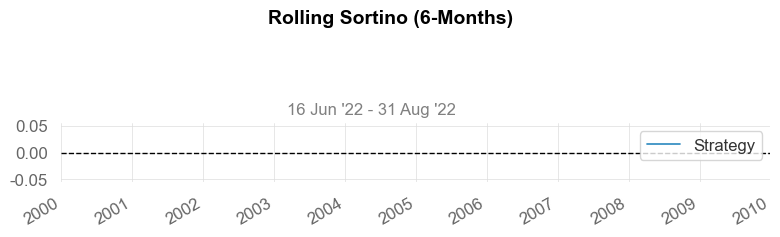

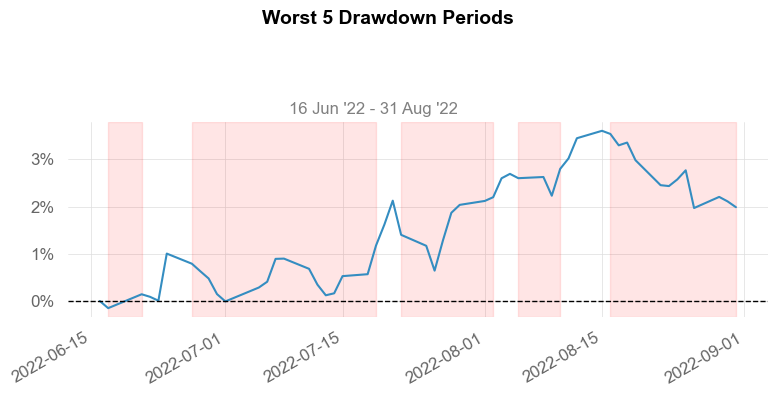

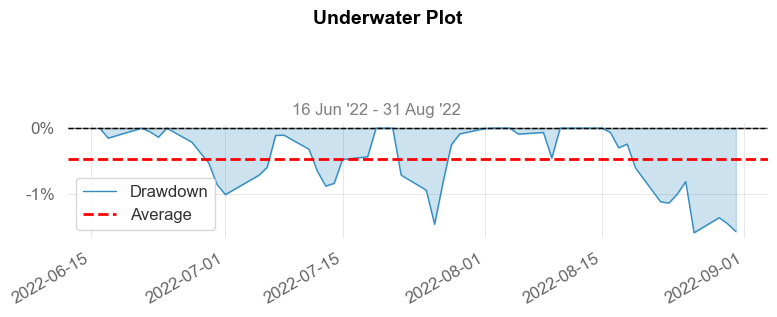

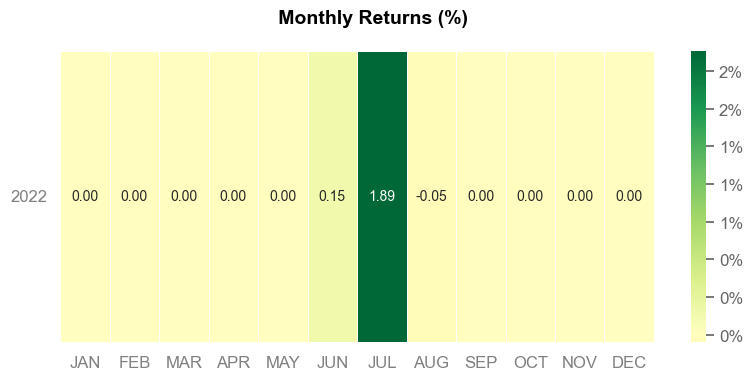

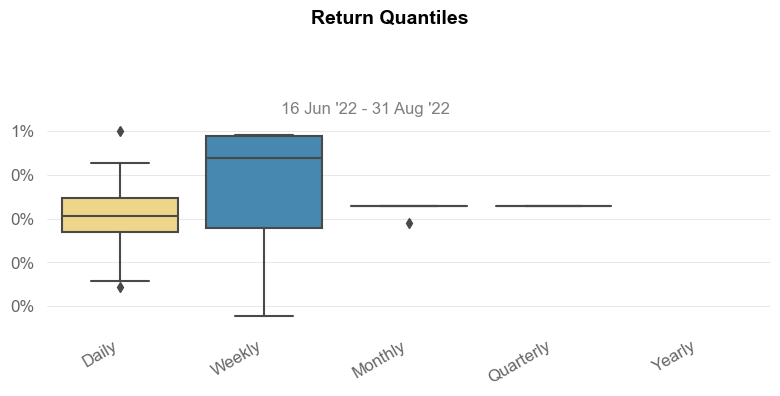

In [50]:
ModelwSentiment(tickers_to_predict=['META'])

# Grid Search

In [7]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def ModelwSentimentIter(tickers_to_predict=['AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, intercept = False):
    retsSpreads = []
    for tick in tickers_to_predict:
        #TODO: read from csv file instead of pulling live data to match the sentiment predictions by Elton
        yhist = readDailyReturnsFromCsv([tick])
        yhist.index = pd.to_datetime(yhist.index, utc=True).date
        yhist.index.rename('Date', inplace=True)


        # returns data
        Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
        if tick in Xhist_rets.columns:
            Xhist_rets.drop(columns=tick, inplace=True)
        Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
        Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        # get betas
        if intercept:
            ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
        else:
            #TODO: add sentiment here
            ols = RollingOLS(yhist, Xhist, window=window).fit()
        betas = ols.params.dropna()
        # get weights
        if intercept:
            spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            #TODO: add sentiment here
            # spread is the residuals
            spread = yhist[tick] - (betas * (Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        # print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        # drop predicted sentiment data as tradeable stock
        if tick in betas.columns:
            betas = betas.drop(columns=tick, inplace=False)
        if tick in weights.columns:
            weights.drop(columns=tick, inplace=True)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)
    print(sharpe)
    return sharpe
    # qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

In [ ]:
ModelwSentimentIter(tickers_to_predict=['META'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Filtered/Tuned', sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 15, thresh = 1, intercept = False)

In [46]:
ModelwSentimentIter()

0.22495892549345683


/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/114049611.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)


0.22495892549345683

In [35]:
for p in itertools.product(windows, intercepts):
    print(p)

(90, False)
(90, True)
(120, False)
(120, True)
(150, False)
(150, True)


## Search (Old data before filtering and tuning)

In [62]:
import itertools
windows = [90, 120, 150]
z_lookbacks = [15, 30, 45]
sentiment_files = ['/finbert_pred_returns_rfr_test.csv', '/flair_pred_returns_rfr_test.csv', '/vader_pred_returns_rfr_test.csv', '/stacked_pred_returns_rfr_test.csv']
intercepts = [False, True]
thresh = [0.75, 1, 1.5, 2]
tickers_sets_to_predict = [['AAPL', 'TSLA', 'META'], ['META', 'TSLA'], ['META'], ['TSLA'], ['AAPL']]

search_path = []
best_params = tuple()
best_Sharpe = 0

for params in itertools.product(tickers_sets_to_predict, sentiment_files, windows, z_lookbacks, thresh, intercepts):
    ts, s, w, z, t, i = params
    sharpe = ModelwSentimentIter(tickers_to_predict=ts, sentiment_file=s, window=w, lookback=z, thresh=t, intercept=i)
    performance = list(params)
    performance.append(sharpe)
    search_path.append(performance)

    if sharpe > best_Sharpe:
        best_Sharpe = sharpe
        best_params = params
        print('new best Sharpe ratio found!',best_Sharpe)
        print('new best params', best_params)
    

-1.041
-0.791
-0.88
-0.878
-1.517
-1.515
-1.381
-1.371
-1.194
-1.181
-0.702
-0.764
-1.378
-1.371
-1.423
-1.411
-1.339
-1.249
-1.389
-1.186
-1.208
-1.2
-1.343
-1.33
1.456
new best Sharpe ratio found! 1.456
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
1.587
new best Sharpe ratio found! 1.587
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
1.679
new best Sharpe ratio found! 1.679
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
1.722
new best Sharpe ratio found! 1.722
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, True)
0.894
0.923
0.859
0.881
1.344
1.397
1.21
1.172
1.086
1.114
0.859
0.881
0.818
0.865
1.188
1.218
1.086
1.114
0.859
0.881
-3.387
-3.368
-3.736
-2.649
-3.278
-3.28
-3.278
-3.28
-3.627
-3.614
-2.656
-2.649
-3.278
-3.28
-3.278
-3.28
-3.627
-3.614
-2.656
-2.649
-3.278
-3.28


In [63]:
print(best_Sharpe)

3.662


In [64]:
best_params

(['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, False)

In [67]:
search_path_df = pd.DataFrame(search_path, columns=['tickers_to_predict', 'sentiment_filepath', 'window', 'lookback', 'thresh', 'intercept', 'Sharpe_ratio'])
search_path_df.sort_values(by='Sharpe_ratio', ascending=False, inplace=True)
search_path_df.head()

In [78]:
search_path_df.to_csv('linear_reg_search.csv', index=False)

In [83]:
sum(search_path_df['Sharpe_ratio']>1)

284

In [84]:
sum(search_path_df['Sharpe_ratio']>2)

60

## Search on New data (after Filtering, Tuning and Lagging)

In [8]:
import itertools
windows = [90, 120, 150]
z_lookbacks = [15, 30, 45]
sentiment_files = ['/finbert_fmax_pred_returns_rfr_test.csv', '/finbert_fmean_pred_returns_rfr_test.csv']
intercepts = [False, True]
thresh = [0.75, 1, 1.5, 2]
tickers_sets_to_predict = [['AAPL', 'TSLA', 'META'], ['META', 'TSLA'], ['META'], ['TSLA'], ['AAPL']]

search_path = []
best_params = tuple()
best_Sharpe = 0

for params in itertools.product(tickers_sets_to_predict, sentiment_files, windows, z_lookbacks, thresh, intercepts):
    ts, s, w, z, t, i = params
    sharpe = ModelwSentimentIter(tickers_to_predict=ts, sentiment_filepath='../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Filtered/Tuned', sentiment_file=s, window=w, lookback=z, thresh=t, intercept=i)
    performance = list(params)
    performance.append(sharpe)
    search_path.append(performance)

    if sharpe > best_Sharpe:
        best_Sharpe = sharpe
        best_params = params
        print('new best Sharpe ratio found!',best_Sharpe)
        print('new best params', best_params)
    

-0.714
-0.95
-0.555
-0.481
-0.522
-0.408
-0.841
-0.917
-0.822
-0.74
-0.106
-0.257
-0.594
-0.676
-0.886
-0.963
-0.751
-0.799
-0.464
-0.353
-0.659
-0.733
-0.842
-0.931
0.829
new best Sharpe ratio found! 0.829
new best params (['AAPL', 'TSLA', 'META'], '/finbert_fmax_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
0.545
1.562
new best Sharpe ratio found! 1.562
new best params (['AAPL', 'TSLA', 'META'], '/finbert_fmax_pred_returns_rfr_test.csv', 120, 15, 1, False)
1.558
0.643
0.627
0.451
0.431
1.245
1.452
1.115
1.099
0.581
0.569
0.451
0.431
1.765
new best Sharpe ratio found! 1.765
new best params (['AAPL', 'TSLA', 'META'], '/finbert_fmax_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
1.721
0.991
0.977
0.659
0.647
0.451
0.431
-2.845
-2.46
-1.985
-1.982
-2.619
-2.616
-2.619
-2.616
-2.472
-2.46
-1.985
-1.982
-2.619
-2.616
-2.619
-2.616
-2.609
-2.46
-1.985
-1.982
-2.619
-2.616
-2.619
-2.616
-0.668
-0.706
-0.914
-0.485
-0.806
-0.787
-0.874
-0.84
-1.037
-0.873
-0.278
0.023
-0.824
-0.801
-0.

In [9]:
best_Sharpe

2.943

In [10]:
best_params

(['META'], '/finbert_fmean_pred_returns_rfr_test.csv', 120, 15, 1, True)

In [11]:
search_path_df = pd.DataFrame(search_path, columns=['tickers_to_predict', 'sentiment_filepath', 'window', 'lookback', 'thresh', 'intercept', 'Sharpe_ratio'])
search_path_df.sort_values(by='Sharpe_ratio', ascending=False, inplace=True)
search_path_df.head()

,tickers_to_predict,sentiment_filepath,window,lookback,thresh,intercept,Sharpe_ratio
387,[META],/finbert_fmean_pred_returns_rfr_test.csv,120,15,1.0,True,2.943
386,[META],/finbert_fmean_pred_returns_rfr_test.csv,120,15,1.0,False,2.900
314,[META],/finbert_fmax_pred_returns_rfr_test.csv,120,15,1.0,False,2.866
315,[META],/finbert_fmax_pred_returns_rfr_test.csv,120,15,1.0,True,2.774
170,"[META, TSLA]",/finbert_fmax_pred_returns_rfr_test.csv,120,15,1.0,False,2.554


In [12]:
search_path_df.to_csv('linear_reg_search2.csv', index=False)

In [17]:
search_path_old_df = pd.read_csv('linear_reg_search.csv')
search_path_old_df.head()

,tickers_to_predict,sentiment_filepath,window,lookback,thresh,intercept,Sharpe_ratio
0,['META'],/vader_pred_returns_rfr_test.csv,120,15,1.00,False,3.662
1,['META'],/stacked_pred_returns_rfr_test.csv,120,30,0.75,True,3.594
2,['META'],/stacked_pred_returns_rfr_test.csv,120,15,1.00,True,3.314
3,"['META', 'TSLA']",/stacked_pred_returns_rfr_test.csv,120,30,0.75,True,3.296
4,"['META', 'TSLA']",/stacked_pred_returns_rfr_test.csv,120,15,0.75,True,3.291


## Search on Tuned and Lagged but not Filtered

In [34]:
import itertools
windows = [90, 120, 150]
z_lookbacks = [15, 30, 45]
sentiment_files = ['/finbert_pred_returns_rfr_test.csv', '/flair_pred_returns_rfr_test.csv', '/stacked_pred_returns_rfr_test.csv', '/vader_pred_returns_rfr_test.csv']
intercepts = [False, True]
thresh = [0.75, 1, 1.5, 2]
tickers_sets_to_predict = [['AAPL', 'TSLA', 'META'], ['META', 'TSLA'], ['META'], ['TSLA'], ['AAPL']]

search_path_tl = []
best_params = tuple()
best_Sharpe = 0

for params in itertools.product(tickers_sets_to_predict, sentiment_files, windows, z_lookbacks, thresh, intercepts):
    ts, s, w, z, t, i = params
    sharpe = ModelwSentimentIter(tickers_to_predict=ts, sentiment_filepath='../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Tuned', sentiment_file=s, window=w, lookback=z, thresh=t, intercept=i)
    performance = list((tuple(ts), s, w, z, t, i))
    performance.append(sharpe)
    search_path_tl.append(performance)

    if sharpe > best_Sharpe:
        best_Sharpe = sharpe
        best_params = params
        print('new best Sharpe ratio found!',best_Sharpe)
        print('new best params', best_params)
    

-0.871
-0.822
-0.954
-1.371
-1.056
-1.089
-1.22
-1.295
-1.293
-1.457
-0.574
-0.627
-1.07
-1.15
-1.175
-1.292
-1.021
-1.108
-1.157
-1.311
-1.07
-1.15
-1.216
-1.292
0.695
new best Sharpe ratio found! 0.695
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
0.598
2.02
new best Sharpe ratio found! 2.02
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
1.951
0.964
0.888
0.84
0.762
1.342
1.287
1.367
1.207
1.028
0.95
0.84
0.762
1.023
0.965
1.367
1.207
0.84
0.762
0.84
0.762
-3.562
-3.681
-2.555
-2.646
-3.065
-3.142
-3.065
-3.142
-3.557
-4.181
-2.555
-2.646
-3.065
-3.142
-3.065
-3.142
-4.093
-4.181
-2.555
-2.646
-3.065
-3.142
-3.065
-3.142
-1.336
-1.479
-1.053
-0.661
-0.856
-0.85
-1.106
-1.1
-1.011
-1.412
-0.369
-0.504
-0.93
-0.923
-1.064
-1.057
-1.265
-1.374
-0.944
-0.714
-0.93
-0.923
-1.064
-1.057
1.648
1.602
2.128
new best Sharpe ratio found! 2.128
new best params (['AAPL', 'TSLA', 'META'], 

In [35]:
search_path_tl_df = pd.DataFrame(search_path_tl, columns=['tickers_to_predict', 'sentiment_filepath', 'window', 'lookback', 'thresh', 'intercept', 'Sharpe_ratio'])
search_path_tl_df.sort_values(by='Sharpe_ratio', ascending=False, inplace=True)
search_path_tl_df.head()

,tickers_to_predict,sentiment_filepath,window,lookback,thresh,intercept,Sharpe_ratio
602,"(META,)",/finbert_pred_returns_rfr_test.csv,120,15,1.0,False,3.744
747,"(META,)",/stacked_pred_returns_rfr_test.csv,120,15,1.0,True,3.333
675,"(META,)",/flair_pred_returns_rfr_test.csv,120,15,1.0,True,3.253
603,"(META,)",/finbert_pred_returns_rfr_test.csv,120,15,1.0,True,3.227
674,"(META,)",/flair_pred_returns_rfr_test.csv,120,15,1.0,False,3.209


In [36]:
search_path_tl_df.to_csv('linear_reg_search_tl.csv', index=False)

In [42]:
search_path_tl_df['tickers_to_predict'].unique()

array([('META',), ('META', 'TSLA'), ('TSLA',), ('AAPL', 'TSLA', 'META'),
       ('AAPL',)], dtype=object)

In [44]:
search_path_tl_df.groupby('tickers_to_predict').max('Sharpe_ratio')

,window,lookback,thresh,intercept,Sharpe_ratio
tickers_to_predict,,,,,
"(AAPL,)",150,45,2.0,True,0.448
"(AAPL, TSLA, META)",150,45,2.0,True,2.128
"(META,)",150,45,2.0,True,3.744
"(META, TSLA)",150,45,2.0,True,2.967
"(TSLA,)",150,45,2.0,True,2.531
